In [2]:
%matplotlib notebook

import numpy as np
import math
import time
import scipy.stats as sta
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

import winsound
import pickle

W = 60    # Time frame window: 60 frames (= 2 seconds)


In [3]:
# Retrieve data from the given file to separate lists
def get_data(filename):
    global frame_num_count, frame_num
    global x, y, z, velocity, intensity
    
    # Open file
    with open(filename, "r") as f:
        lines = f.readlines()

    wordlist = []
    for line in lines:
        for word in line.split():
            wordlist.append(word)

    for i in range(0, len(wordlist)):
        if wordlist[i] == "point_id:" and wordlist[i+1] == "0":
            frame_num_count += 1
        if wordlist[i] == "point_id:":
            frame_num.append(frame_num_count)
        if wordlist[i] == "x:":
            x.append(wordlist[i+1])
        if wordlist[i] == "y:":
            y.append(wordlist[i+1])
        if wordlist[i] == "z:":
            z.append(wordlist[i+1])
        if wordlist[i] == "velocity:":
            velocity.append(wordlist[i+1])
        if wordlist[i] == "intensity:":
            intensity.append(wordlist[i+1])

    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    frame_num = np.asarray(frame_num)
    velocity = np.asarray(velocity)
    intensity = np.asarray(intensity)

    x = x.astype(np.float)
    y = y.astype(np.float)
    z = z.astype(np.float)
    velocity = velocity.astype(np.float)
    intensity = intensity.astype(np.float)
    frame_num = frame_num.astype(np.int)



In [4]:
# Organize data in multiple lists to a list "final"
def organized_data():
    data = dict()
    final = np.zeros([len(frame_num), 6])
    
    for i in range(len(frame_num)):
        if int(frame_num[i]) in data:
            data[frame_num[i]].append([x[i], y[i], z[i], velocity[i], intensity[i]])
        else:
            data[frame_num[i]] = []
            data[frame_num[i]].append([x[i], y[i], z[i], velocity[i], intensity[i]])

        final[i, 0] = int(frame_num[i])
        final[i, 1] = x[i]
        final[i, 2] = y[i]
        final[i, 3] = z[i]
        final[i, 4] = velocity[i]
        final[i, 5] = intensity[i]

    return data, final


In [5]:
# Define the function to fit distribution in Z dimension
def Gaussian2(x, *par):
    return par[0]*np.exp(-np.power(x-par[2], 2) / (2 * np.power(par[4], 2))) + par[1]*np.exp(-np.power(x-par[3], 2) / (2 * np.power(par[5], 2)))


In [6]:
# To find x_min, x_max
def find_x_bounds(x_data, pillar = 32, debug = False):
    kwargs = {'color': 'b'}
    if debug:
        plt.figure()
        ver, hor, patch = plt.hist(x_data, bins = pillar, density = True, **kwargs)
    else:
        ver, hor = np.histogram(x_data, bins = pillar, density = True)
    mean = np.mean(x_data)
    std = np.std(x_data)
    fit = sta.norm.pdf(hor, mean, std)
    fwhm1 = (max(fit)+fit[0])/2
    fwhm2 = (max(fit)+fit[-1])/2

    x_min = min(x_data)
    x_max = max(x_data)
    for i in range(len(fit)-1):
        if fit[i] < fwhm1 <= fit[i+1]:
            x_min = hor[i+1]
        elif fit[i] >= fwhm2 > fit[i+1]:
            x_max = hor[i]

    if debug:
        kwargs = {'color': 'orange'}
        plt.plot(hor, fit, **kwargs)
        plt.xlabel("X")
        plt.axvline(x=x_min, **kwargs)
        plt.axvline(x=x_max, **kwargs)
        print("x_min=" + str(x_min) + "\tx_max=" + str(x_max))

    return x_min, x_max


In [7]:
# To find y_min, y_max
def find_y_bounds(y_data, pillar = 32, debug = False):
    kwargs = {'color': 'b'}
    if debug:
        plt.figure()
        ver, hor, patch = plt.hist(y_data, bins = pillar, density = True, **kwargs)
    else:
        ver, hor = np.histogram(y_data, bins = pillar, density = True)
    mean = np.mean(y_data)
    std = np.std(y_data)

    y_min = min(y_data)
    y_max = max(y_data)
    y_min = max(y_min, mean-3*std)
    y_max = min(y_max, mean+3*std)

    if debug:
        kwargs = {'color': 'orange'}
        fit = sta.norm.pdf(hor, mean, std)
        plt.plot(hor, fit, **kwargs)
        plt.xlabel("Y")
        plt.axvline(x=y_min, **kwargs)
        plt.axvline(x=y_max, **kwargs)
        print("y_min=" + str(y_min) + "\ty_max=" + str(y_max))

    return y_min, y_max


In [8]:
# To find z_min, z_max
def find_z_bounds(z_data, pillar = 32, debug = False, cov0 = 0.3):
    kwargs = {'color': 'b'}
    if debug:
        plt.figure()
        ver, hor, patch = plt.hist(z_data, bins = pillar, density = True, **kwargs)
    else:
        ver, hor = np.histogram(z_data, bins = pillar, density = True)
    fit, cov = curve_fit(Gaussian2, hor[:-1], ver, p0=[1,1,0,1,cov0,cov0])

    z_min = min(z_data)
    z_max = max(z_data)
    z_min = max(z_min, fit[2]-3*fit[4])
    z_max = min(z_max, fit[2]+3*fit[4])  # Gap between two Gaussians

    if debug:
        kwargs = {'color': 'orange'}
        plt.plot(hor, Gaussian2(hor, *fit), **kwargs)
        plt.xlabel("Z")
        plt.axvline(x=z_min, **kwargs)
        plt.axvline(x=z_max, **kwargs)
        print("z_min=" + str(z_min) + "\tz_max=" + str(z_max))
        print(fit[2], fit[4])

    return z_min, z_max


In [9]:
# TODO: Not tested yet, for future work
def train_z_cov(z_data, pillar = 32, cov0 = 0.3, step = 0.02):
    z_min = 0
    z_max = 0
    cov = cov0
    while z_min == 0 and z_max == 0:
        try:
            z_min, z_max = find_z_bounds(z_data, pillar = pillar, cov0 = cov)
        except:
            cov += step
    return z_min, z_max


In [212]:
# To filter out noises
def sort_data(startFrame, endFrame, clean = True):
    i_prev = 0
    for i in range(len(frame_num)):
        if frame_num[i] == startFrame - 1:
            i_prev = i
            continue
        if frame_num[i] == endFrame:
            i_curr = i
            break

    print("time="+str(startFrame/30)+"s\tstartFrame="+str(startFrame)+"\tendFrame="+str(endFrame)+"\ti_prev="+str(i_prev)+"\ti_curr="+str(i_curr))

    # Gaussian fit, similar to the method of voxels
    pillar = 32
    x_min, x_max = find_x_bounds(x[i_prev:i_curr], pillar)
    y_min, y_max = find_y_bounds(y[i_prev:i_curr], pillar)
    
    # z: curve_fit may not converge -> use iterative train_z_cov
    try:
        z_min, z_max = find_z_bounds(z[i_prev:i_curr], pillar)
    except:
        z_min, z_max = find_x_bounds(z[i_prev:i_curr], pillar)

    # print(x_min, x_max, y_min, y_max, z_min, z_max)

    i_list = []
    for i in range(i_prev, i_curr):
        if clean:
            if x_min <= x[i] <= x_max and z_min <= z[i] <= z_max:
                i_list.append(i)
        else:
            i_list.append(i)

    # print("i_list = " + str(i_list))
    return i_list


In [11]:
# Sorting order matters, x based on sorted z, y based on sorted x and z (z -> x -> y, because z most effective according to the preprocess, x being the next, y the least)
# Drawbacks: two more loops, calculation heavier (0.2s more)
def sort_data2(startFrame, endFrame, clean = True):
    i_prev = 0
    for i in range(len(frame_num)):
        if frame_num[i] == startFrame - 1:
            i_prev = i
            continue
        if frame_num[i] == endFrame:
            i_curr = i
            break

    print("time="+str(startFrame/30)+"s\tstartFrame="+str(startFrame)+"\tendFrame="+str(endFrame)+"\ti_prev="+str(i_prev)+"\ti_curr="+str(i_curr))

    # Gaussian fit, similar to the method of voxels
    pillar = 32

    # For z_min, z_max
    # z: curve_fit may not converge -> use iterative train_z_cov
    try:
        z_min, z_max = find_z_bounds(z[i_prev:i_curr], pillar)
    except:
        z_min, z_max = find_x_bounds(z[i_prev:i_curr], pillar)

    # For x_min, x_max
    i_list_x = []
    for i in range(i_prev, i_curr):
        if z_min <= z[i] <= z_max:
            i_list_x.append(i)
    if i_list_x == []:
        return []
    else:
        x_min, x_max = find_x_bounds(x[i_list_x], pillar)

    # For y_min, y_max
    i_list_y = []
    for i in i_list_x:
        if x_min <= x[i] <= x_max:
            i_list_y.append(i)
    if i_list_y == []:
        return []
    else:
        y_min, y_max = find_y_bounds(y[i_list_y], pillar)

    # print(x_min, x_max, y_min, y_max, z_min, z_max)

    i_list = []
    
    if clean:
        for i in i_list_y:
            if y_min <= y[i] <= y_max:
                i_list.append(i)
    else:
        for i in range(i_prev, i_curr):
            i_list.append(i)

    # print("i_list = " + str(i_list))
    return i_list


In [259]:
# Use graph community (fast greedy) to denoise (locate signal from noise)
# Slow when running, about 3 min for each 60-frame window
def sort_data_graph(startFrame, endFrame, final, threshold = 0.2):
    i_prev = 0
    for i in range(len(frame_num)):
        if frame_num[i] == startFrame - 1:
            i_prev = i
            continue
        if frame_num[i] == endFrame:
            i_curr = i
            break
    i_count = i_curr - i_prev
    
    print("time="+str(startFrame/30)+"s\tstartFrame="+str(startFrame)+"\tendFrame="+str(endFrame)+"\ti_prev="+str(i_prev)+"\ti_curr="+str(i_curr))
    
    # Adjacency matrix
    A = np.zeros((i_count, i_count))
    for i in range(i_count):
        for j in range(i, i_count):
            dist = np.linalg.norm(final[np.array(range(i_prev, i_curr))[i]][1:4] - final[np.array(range(i_prev, i_curr))[j]][1:4])
            if dist > threshold or dist == 0:
                A[i, j] = 0
                A[j, i] = 0
            else:
                A[i, j] = 1
                A[j, i] = 1
    
    # Build graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    # Find community
    G_community = greedy_modularity_communities(G)
    # Translate graph index to frame_num index
    i_list_graph = []
    for each in G_community:
        i_list_graph.append(np.array(range(i_prev, i_curr))[list(each)])
    
    # Find which one of the graph clusters represent human figure: max sum abs velocity
    score_list = []
    for cluster in i_list_graph:
        score = 0
        for point in cluster:
            score += abs(final[point, 4])
        score_list.append(score)
    
    if score_list[np.argmax(score_list)] > 0:
        return i_list_graph[np.argmax(score_list)]
    else:
        return []


<IPython.core.display.Javascript object>


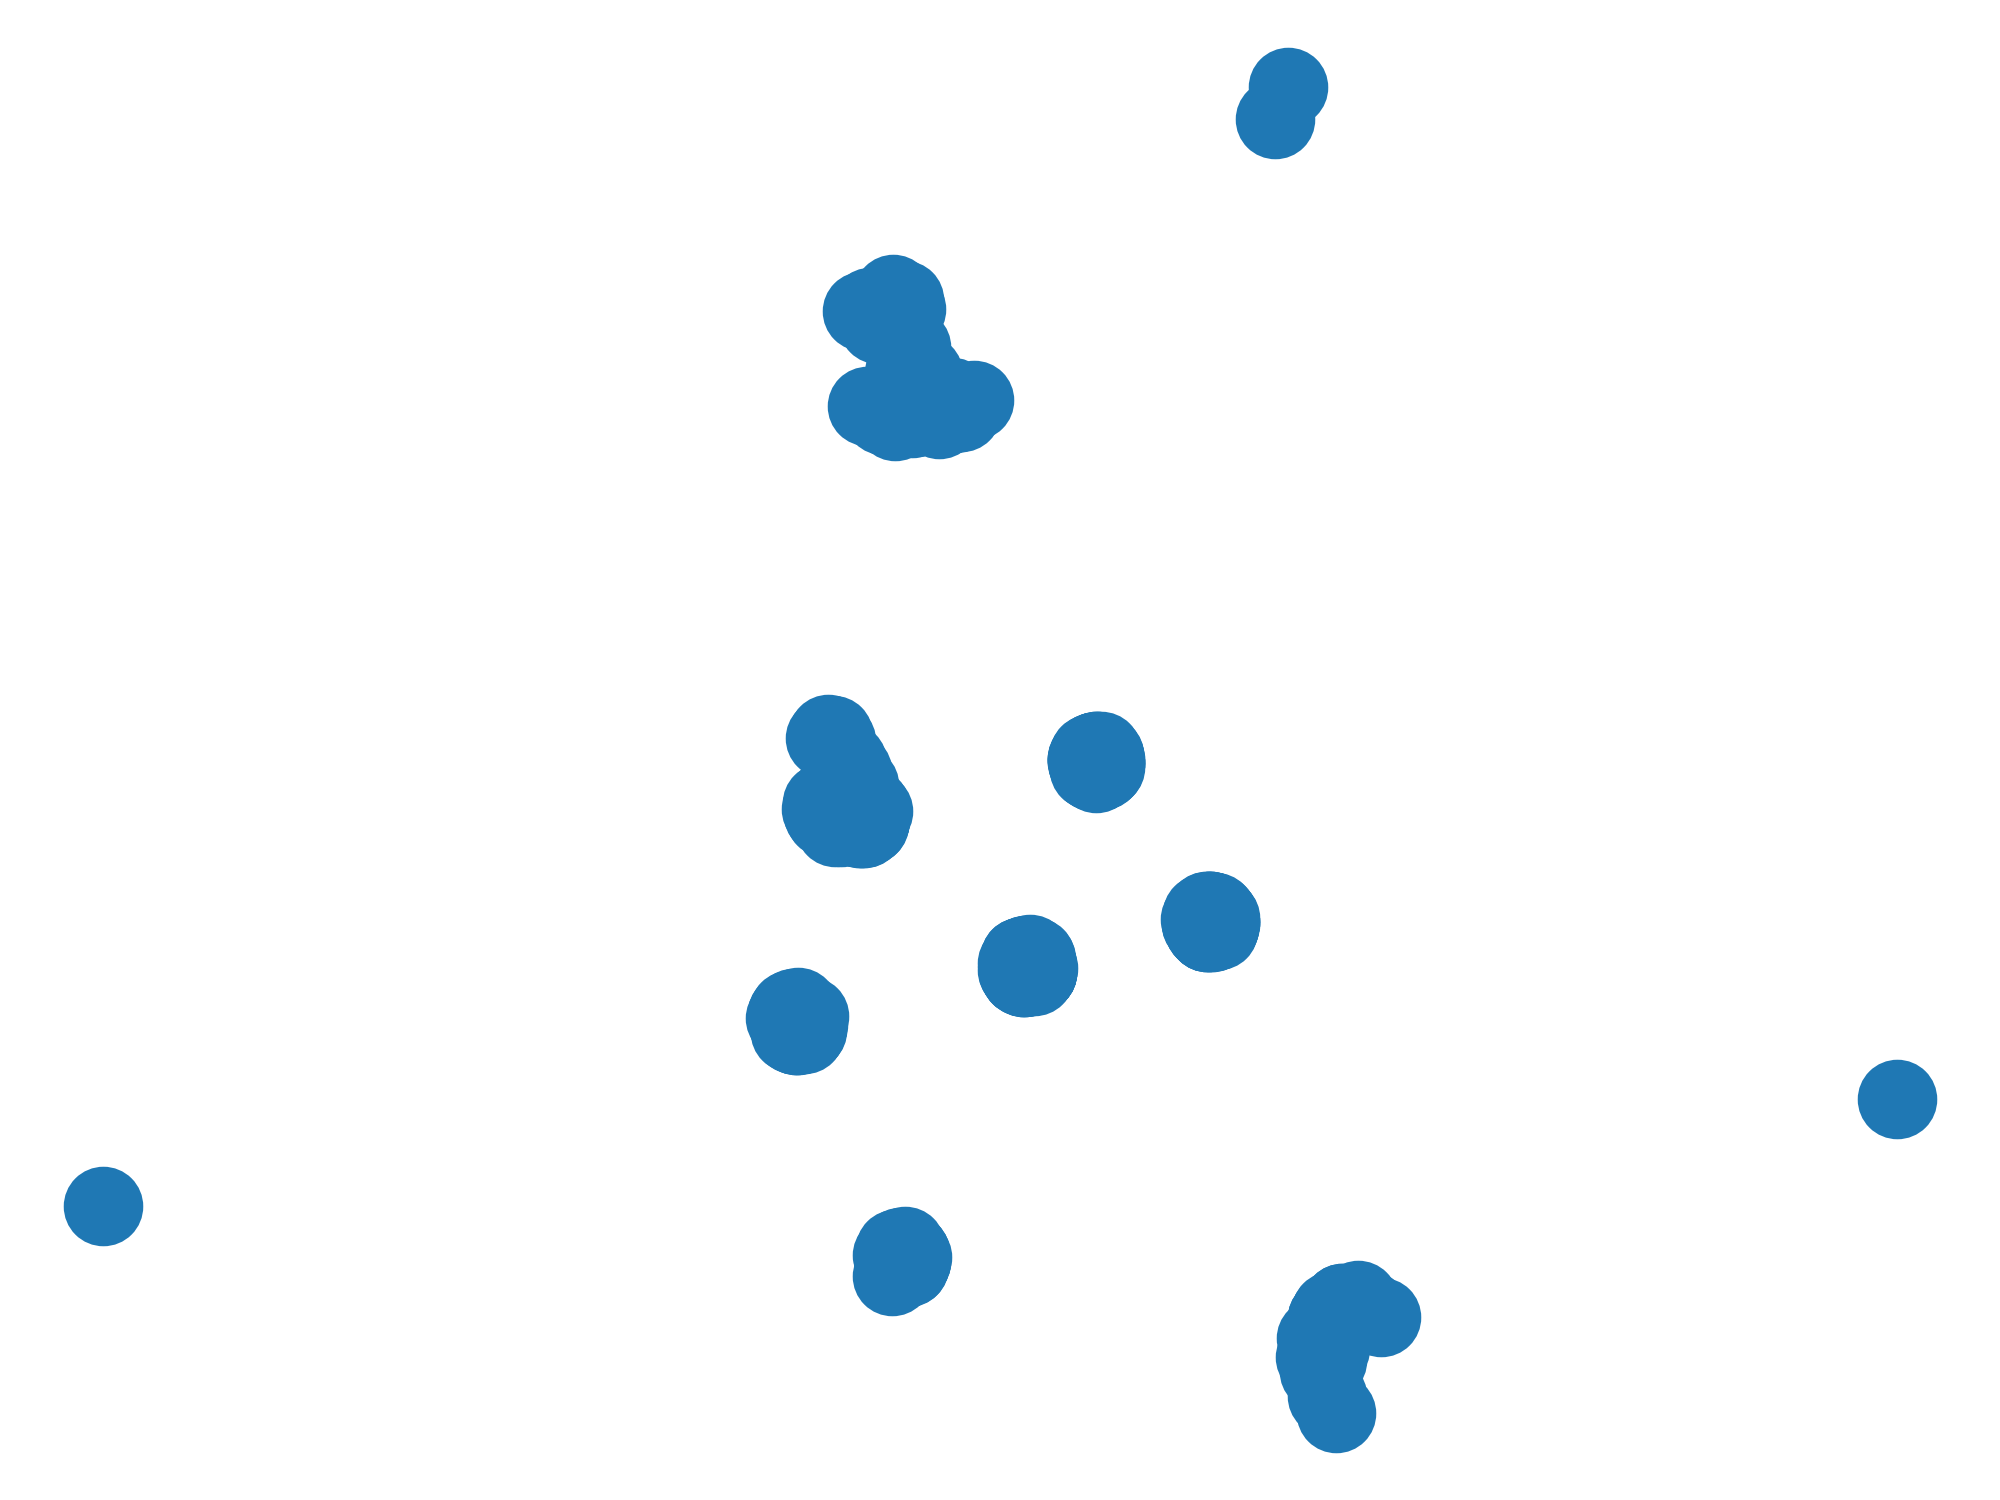

In [326]:
plt.figure()
nx.draw(G)
plt.show()

<IPython.core.display.Javascript object>


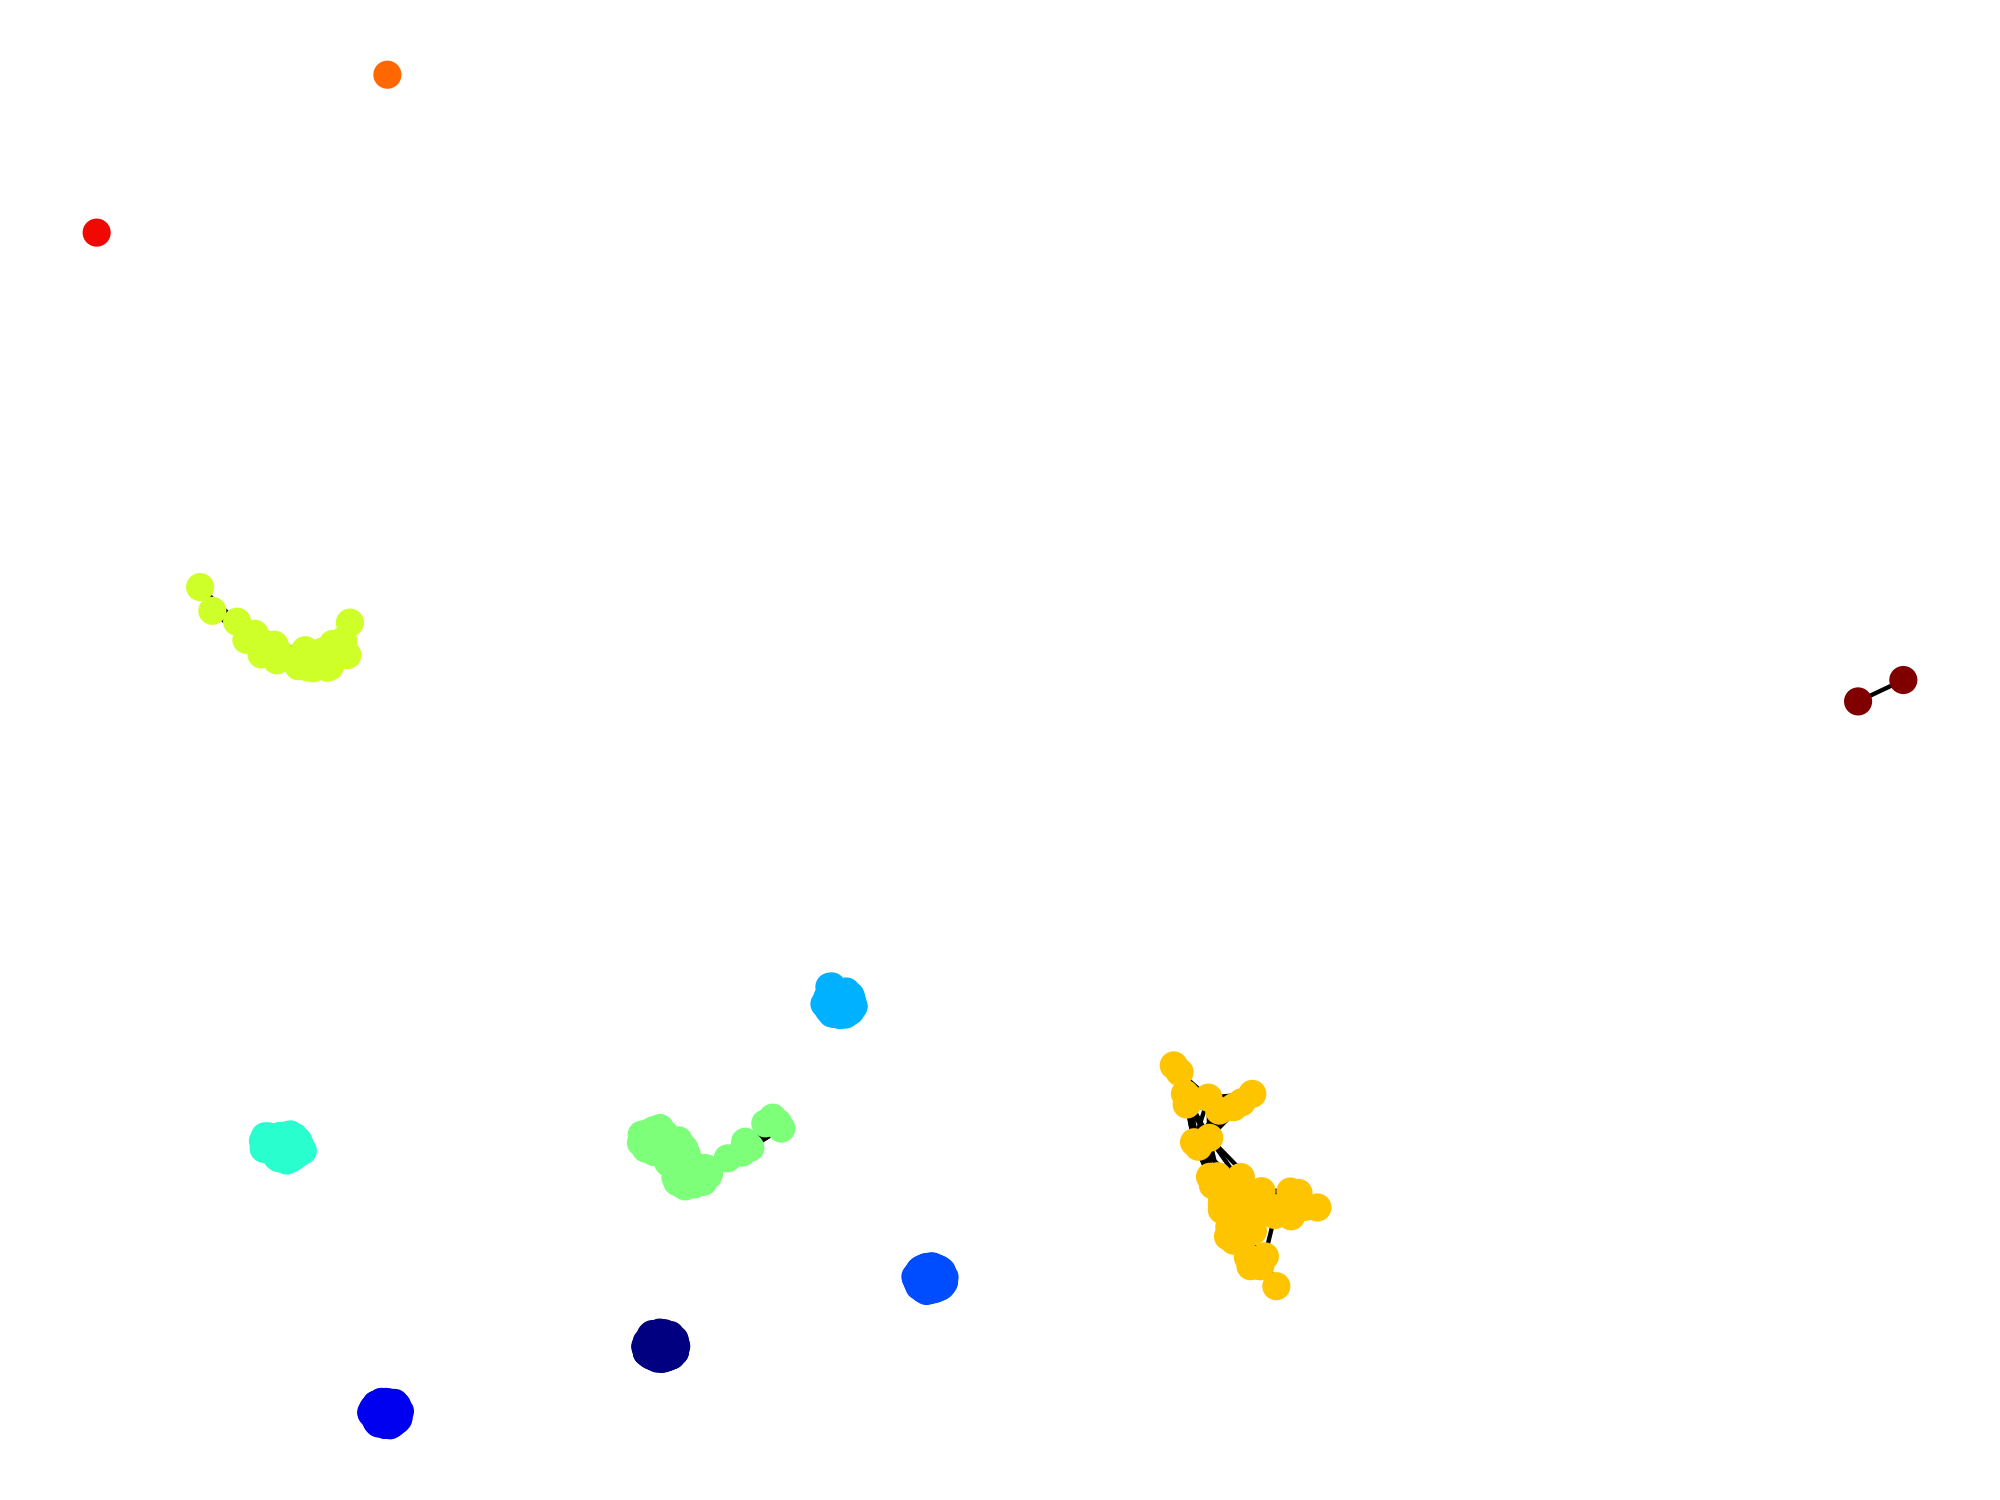

In [325]:
import community
plt.figure()
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.show()

In [13]:
# Shift and add
# Problem: if sorted data not clean enough, max velocity point may fall in noises, making the shifted data a mess -> Solution: use sort_data2 func, a lot cleaner
# Problem: data too sparse for 1 frame, may or may not have large distance change in 60 frames -> Solution: shift and add every 10 frame (?)
def shift_data(i_list):
    center = expect(i_list)

    final2 = np.zeros([len(frame_num), 6])

    # data2: To store frame_index with same frame_number in a dict
    data2 = dict()
    for i in i_list:
        if int(frame_num[i]) in data2:
            data2[frame_num[i]].append(i)
        else:
            data2[frame_num[i]] = []
            data2[frame_num[i]].append(i)

    # TODO: use the expected point as a reference, instead of the max_velocity point
    # Shift each frame so that all velocity_max points for each frame in the same position as center of every 60 frames
    for each_frame in data2:
        vel_max_frame_index = data2[each_frame][np.argmax(velocity[data2[each_frame]])]
        for i in data2[each_frame]:
            final2[i, 0] = int(frame_num[i])
            final2[i, 1] = x[i] - (x[vel_max_frame_index] - center[0])
            final2[i, 2] = y[i] - (y[vel_max_frame_index] - center[1])
            final2[i, 3] = z[i] - (z[vel_max_frame_index] - center[2])
            final2[i, 4] = velocity[i]
            final2[i, 5] = intensity[i]

    return final2


In [14]:
def normalize(x, x_min, x_max):
    return (x-x_min)/(x_max-x_min)


In [15]:
# Estimate the center position of the figure
# "index" choices:
# = 1: max velocity
# = 2: max intensity
# = 3: combined max velocity and intensity
# = 4: velocity-weighted
# = 5: intensity-weighted
# = 6: combined velocity & intensity-weighted
# = 7: average of all position
def expect(i_list, index = 5, vel_weight = 0.5):

    # Use the point with max velocity/intensity as the estimated center
    if index in [1, 2]:
        i_max = i_list[np.argmax(np.abs(final[i_list, index + 3]))]
        x = x[i_max]
        y = y[i_max]
        z = z[i_max]
        return [x, y, z]

    # Use max combined velocity/intensity
    if index == 3:
        i_max = i_list[np.argmax(np.abs(final[i_list, 4]) * vel_weight + np.abs(final[i_list, 5]) * (1 - vel_weight))]
        x = x[i_max]
        y = y[i_max]
        z = z[i_max]
        return [x, y, z]

    if index == 7:
        x = np.average(final[i_list, 1])
        y = np.average(final[i_list, 2])
        z = np.average(final[i_list, 3])
        return [x, y, z]

    # Use the velocity(/intensity)-weighted expected position as the estimated center
    if index in [4, 5]:
        weight = np.abs(final[i_list, index])
    elif index == 6:
        weight = np.abs(final[i_list, 4]) * vel_weight + np.abs(final[i_list, 5]) * (1 - vel_weight)

    if np.sum(weight) != 0:
        x = np.dot(final[i_list, 1], weight)/np.sum(weight)
        y = np.dot(final[i_list, 2], weight)/np.sum(weight)
        z = np.dot(final[i_list, 3], weight)/np.sum(weight)
    else:
        x = np.average(final[i_list, 1])
        y = np.average(final[i_list, 2])
        z = np.average(final[i_list, 3])
    return [x, y, z]


In [16]:
def find_verts(i_list, datalist):
    x_min = min(datalist[i_list, 1])
    x_max = max(datalist[i_list, 1])
    y_min = min(datalist[i_list, 2])
    y_max = max(datalist[i_list, 2])
    z_min = min(datalist[i_list, 3])
    z_max = max(datalist[i_list, 3])
    # velocity_min = min(datalist[i_list, 4])
    # velocity_max = max(datalist[i_list, 4])
    # intensity_min = min(datalist[i_list, 5])
    # intensity_max = max(datalist[i_list, 5])

    center = expect(i_list)

    verts = [x_min, x_max, y_min, y_max, z_min, z_max, center]

    return verts


In [17]:
def plot_data(ax, i_list, datalist, color = 'k', index = 5):
    # index = 4: use "velocity" for alpha; = 5: use "intensity" for alpha
    weight_min = min(np.abs(datalist[i_list, index]))
    weight_max = max(np.abs(datalist[i_list, index]))

    for i in i_list:
        if index in [4, 5]:
            alpha = normalize(abs(datalist[i, index]), weight_min, weight_max)
        else:
            alpha = 1
        ax.scatter(datalist[i, 1], datalist[i, 2], datalist[i, 3], color = color, alpha = alpha, marker = '.')


In [18]:
def plot_cube(ax, verts, alpha = 1, color = 'r', plot_center = False):
    x_min, x_max, y_min, y_max, z_min, z_max, center = verts

    xx = [x_min, x_min, x_max, x_max, x_min]
    yy = [y_min, y_max, y_max, y_min, y_min]
    kwargs = {'alpha': alpha, 'color': color}
    ax.plot3D(xx, yy, [z_min]*5, **kwargs)
    ax.plot3D(xx, yy, [z_max]*5, **kwargs)
    ax.plot3D([x_min, x_min], [y_min, y_min], [z_min, z_max], **kwargs)
    ax.plot3D([x_min, x_min], [y_max, y_max], [z_min, z_max], **kwargs)
    ax.plot3D([x_max, x_max], [y_min, y_min], [z_min, z_max], **kwargs)
    ax.plot3D([x_max, x_max], [y_max, y_max], [z_min, z_max], **kwargs)

    # Plot the center point of the figure
    if plot_center:
        ax.scatter(center[0], center[1], center[2], color = 'r')


In [37]:
def plot_traj(ax, count, i_list_all = []):
    traj = []
    for i in range(0, count):
        if i_list_all == []:
            i_list = sort_data2(i*W, (i+1)*W)
        else:
            i_list = i_list_all[i*10]
            
        if i_list != []:
            # final2 = shift_data(i_list)
            # plot_data(ax, i_list, final2)
            # verts = find_verts(i_list, final2)
            # plot_cube(ax, verts)
            traj.append(expect(i_list))
            del i_list

    traj = np.array(traj)
    ax.plot3D(traj[:, 0], traj[:, 1], traj[:, 2], color = 'b')
    print("effective rate", len(traj), count, len(traj)/count)
    # print(traj)

    # Plot range of the traj
    x_min = min(traj[:, 0])
    x_max = max(traj[:, 0])
    y_min = min(traj[:, 1])
    y_max = max(traj[:, 1])
    z_min = min(traj[:, 2])
    z_max = max(traj[:, 2])
    verts = [x_min, x_max, y_min, y_max, z_min, z_max, 0]
    print(verts[:-1])
    plot_cube(ax, verts, 0.5)


In [20]:
# Average figure size among all frames
def figure_size():
    dis_x = []
    dis_y = []
    dis_z = []

    for i in range(0, int(frame_num_count/W)):
        i_list = sort_data2(i*W, (i+1)*W)
        if len(i_list) > 1:
            final2 = shift_data(i_list)
            verts = find_verts(i_list, final2)
            # x_min, x_max, y_min, y_max, z_min, z_max, center = verts
            dis_x.append(verts[1]-verts[0])
            dis_y.append(verts[3]-verts[2])
            dis_z.append(verts[5]-verts[4])
            del i_list

    # TODO (need debug): why for jump (/etc) data, x(/y/z)_min=0
    print("x_min=" + str(min(dis_x)) + "m\tx_max=" + str(max(dis_x)) + "m\tx_ave=" + str(np.average(dis_x)) + "m")
    print("y_min=" + str(min(dis_y)) + "m\ty_max=" + str(max(dis_y)) + "m\ty_ave=" + str(np.average(dis_y)) + "m")
    print("z_min=" + str(min(dis_z)) + "m\tz_max=" + str(max(dis_z)) + "m\tz_ave=" + str(np.average(dis_z)) + "m")


In [21]:
# Simply use the figure height and perfect/average human body model
# Reference: http://humanproportions.com/
def plot_skeleton(ax, i_list, datalist, color = 'm'):
    x_min, x_max, y_min, y_max, z_min, z_max, center = verts
    x0, y0, z0 = center[:]

    body = []

    # TODO: 
    # if y_max - y_min >= x_max - x_min:
    #     # Posture in y-orientation
    # else:
    #     # Posture in x-orientation
    # (default in y-orientation for now)

    h = z_max - z_min
    body.append([x0, y0, h/2])                          # 0: spine base
    body.append([x0, y0, h*(7/8-1/24)])                 # 1: spine shoulder
    body.append([x0, y0, h*7/8])                        # 2: neck
    body.append([x0, y0, h-h/16])                       # 3: head
    body.append([x0, y0-h/8, body[1][2]])               # 4: left shoulder
    body.append([x0, body[4][1], body[1][2]-1.7*h/8])   # 5: left elbow
    body.append([x0, body[4][1], body[5][2]-1.8*h/8])   # 6: left hand
    body.append([x0, 2*y0-body[4][1], body[4][2]])      # 7: right shoulder
    body.append([x0, body[7][1], body[5][2]])           # 8: right elbow
    body.append([x0, body[7][1], body[6][2]])           # 9: right hand
    body.append([x0, y0-0.1*h, h/2])                    # 10: left hip
    body.append([x0, body[10][1], h/4])                 # 11: left knee
    body.append([x0, body[10][1], 0])                   # 12: left foot
    body.append([x0, 2*y0-body[10][1], body[10][2]])    # 13: right hip
    body.append([x0, body[13][1], body[11][2]])         # 14: right knee
    body.append([x0, body[13][1], body[12][2]])         # 15: right foot

    body = np.array(body)
    body = body + np.array([0, 0, z_min])

    # For plot reference
    # ax.plot3D([x1, x2], [y1, y2], [z1, z2], 'b')
    kwargs = {'color': color, 'marker': '.'}
    ax.plot3D(body[0:4,0], body[0:4,1], body[0:4,2], **kwargs)
    connects = []
    connects.append([1, 4, 5, 6])
    connects.append([1, 7, 8, 9])
    connects.append([0, 10, 11, 12])
    connects.append([0, 13, 14, 15])
    for connect in connects:
        ax.plot3D(body[connect,0], body[connect,1], body[connect,2], **kwargs)
    tips = [3, 6, 9, 12, 15]
    ax.scatter(body[tips,0], body[tips,1], body[tips,2], color = color, marker = 'o')
    plt.axis("square")


In [22]:
# TODO: Below are the second method to estimate figure posture/skeleton, need improvement
# To estimate torso body part
# Intensity-based weighted lower and upper bounds estimation
def find_torso(i_list, datalist):
    center = expect(i_list)

    # Initialize
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0
    z_min = 0
    z_max = 0

    weight_min = 0
    weight_max = 0
    index = 5       # index = 4: use "velocity" as weight; = 5: use "intensity" as weight

    for i in i_list:
        if datalist[i, 1] <= center[0]:
            x_min += datalist[i, 1] * abs(datalist[i, index])
            weight_min += abs(datalist[i, index])
        else:
            x_max += datalist[i, 1] * abs(datalist[i, index])
            weight_max += abs(datalist[i, index])
    x_min = x_min/weight_min
    x_max = x_max/weight_max

    weight_min = 0
    weight_max = 0
    for i in i_list:
        if datalist[i, 2] <= center[1]:
            y_min += datalist[i, 2] * abs(datalist[i, index])
            weight_min += abs(datalist[i, index])
        else:
            y_max += datalist[i, 2] * abs(datalist[i, index])
            weight_max += abs(datalist[i, index])
    y_min = y_min/weight_min
    y_max = y_max/weight_max

    weight_min = 0
    weight_max = 0
    for i in i_list:
        if datalist[i, 3] <= center[2]:
            z_min += datalist[i, 3] * abs(datalist[i, index])
            weight_min += abs(datalist[i, index])
        else:
            z_max += datalist[i, 3] * abs(datalist[i, index])
            weight_max += abs(datalist[i, index])
    z_min = z_min/weight_min
    z_max = z_max/weight_max

    verts = [x_min, x_max, y_min, y_max, z_min, z_max, center]

    return verts


In [23]:
# Use velocity for limbs estimation
def find_limbs(i_list, datalist, torso_verts):
    limbs = []

    argsort = np.argsort(datalist[i_list,:], axis = 0)
    z_min1 = argsort[0][3]  # foot 1
    z_min2 = argsort[1][3]  # foot 2
    z_max = argsort[-1][3]  # head
    y_min = argsort[0][2]   # hand 1
    y_max = argsort[-1][2]  # hand 2

    # Find tips
    limbs.append(i_list[z_max])         # 0: head
    if datalist[i_list[z_min1],2] <= datalist[i_list[z_min2],2]: # smaller y = left
        limbs.append(i_list[z_min1])    # 1: left foot
        limbs.append(i_list[z_min2])    # 2: right foot
    else:
        limbs.append(i_list[z_min2])    # 1: left foot
        limbs.append(i_list[z_min1])    # 2: right foot
    limbs.append(i_list[y_min])         # 3: left hand
    limbs.append(i_list[y_max])         # 4: right hand

    # Find joints
    y_small = []    # point_y <= center_y
    y_big = []      # point_y > center_y
    z_small = []    # point_z <= center_z
    for i in i_list:
        if datalist[i][2] <= torso_verts[2]:
            y_small.append(i)
        elif datalist[i][2] >= torso_verts[3]:
            y_big.append(i)
        if datalist[i][3] <= torso_verts[4]:
            z_small.append(i)
    # TODO: deal with situation when y_small, y_big, z_small == []

    argsort = np.argsort(datalist[y_small,:], axis = 0)
    y_elbow1 = argsort[int(len(y_small)/2)][2]
    argsort = np.argsort(datalist[y_big,:], axis = 0)
    y_elbow2 = argsort[int(len(y_big)/2)][2]
    argsort = np.argsort(datalist[z_small,:], axis = 0)
    z_knee1 = argsort[int(len(z_small)/2)][3]
    z_knee2 = argsort[int(len(z_small)/2)+1][3]

    if datalist[z_small[z_knee1],2] <= datalist[z_small[z_knee2],2]: # smaller y = left
        limbs.append(z_small[z_knee1])  # 5: left knee
        limbs.append(z_small[z_knee2])  # 6: right knee
    else:
        limbs.append(z_small[z_knee2])  # 5: left knee
        limbs.append(z_small[z_knee1])  # 6: right knee
    limbs.append(y_small[y_elbow1])     # 7: left elbow
    limbs.append(y_big[y_elbow2])       # 8: right elbow

    return limbs


In [24]:
# Plot torso and limbs
# Result: not good, easily affected by remainder noise
def plot_skeleton2(ax, i_list, datalist, color = 'm'):
    kwargs = {'color': color, 'marker': '.'}

    torso_verts = find_torso(i_list, datalist)
    x_min, x_max, y_min, y_max, z_min, z_max, center = torso_verts
    plot_cube(ax, torso_verts, color = color)
    
    limbs = find_limbs(i_list, datalist, torso_verts)

    body = []
    body = datalist[limbs,1:4]
    body = list(body)
    body.append([(x_min+x_max)/2, (y_min+y_max)/2, z_max])  # 9: spine shoulder
    body.append([(x_min+x_max)/2, y_min, z_max])    # 10: left shoulder
    body.append([(x_min+x_max)/2, y_max, z_max]) # 11: right shoulder
    body.append([(x_min+x_max)/2, y_min, z_min]) # 12: left hip
    body.append([(x_min+x_max)/2, y_max, z_min]) # 13: right hip
    body = np.array(body)
    # ax.scatter(body[:,0], body[:,1], body[:,2],color='b',alpha=1)

    connects = []
    connects.append([0,9])
    connects.append([3,7,10])
    connects.append([4,8,11])
    connects.append([1,5,12])
    connects.append([2,6,13])

    for connect in connects:
        ax.plot3D(body[connect,0], body[connect,1], body[connect,2], **kwargs)
    ax.scatter(body[:5,0], body[:5,1], body[:5,2], color = color, marker = 'o')
    # for limb in limbs:
        # ax.scatter(datalist[limb,1],datalist[limb,2],datalist[limb,3], color='b')
        # ax.plot3D([center[0],datalist[limb,1]],[center[1],datalist[limb,2]],[center[2],datalist[limb,3]], color='b')
    plt.axis("square")


In [25]:
# Use graph (similar to sort_data_graph) to find human figure's body part
# Result not good, threshold difficult to set
# Even if dynamically search for a threshold to limit cluster num, result not good
# TODO: need improve
def find_figure_cluster(i_list, final, threshold = 0.07):
    point_count = len(i_list)

    # Adjacency matrix
    A = np.zeros((point_count, point_count))
    for i in range(point_count):
        for j in range(i, point_count):
            dist = np.linalg.norm(final[i_list[i]][1:4] - final[i_list[j]][1:4])
            if dist > threshold or dist == 0:
                A[i, j] = 0
                A[j, i] = 0
            else:
                A[i, j] = 1
                A[j, i] = 1
    
    # Build graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    # Find community
    G_community = greedy_modularity_communities(G)

    # Translate graph index to frame_num index
    figure_part = []
    for each in G_community:
        if len(list(each)) > 2:
            figure_part.append(i_list[list(each)])

    return figure_part
    

In [180]:
# Plot settings, same for all plots
def ax_settings(ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
#     ax.set_xlim(-1, 5)
#     ax.set_ylim(-1, 2)
#     ax.set_zlim(-0.5, 1.5)


In [31]:
def shift_data2(i_list, mode = "frame_center", frame_patch = 1):
    # mode = "frame_center": shift each frame_patch so that each frame_center == center of all frames
    # mode = "frame_origin": shift each frame_patch so that each frame_center == origin ([0, 0, 0])
    # mode = "center_origin": shift all frames together so that the center of all frames == origin ([0, 0, 0])
    # mode = "center_xyorigin": shift all frames together in the xy=plane so that the center of all frames == xy origin ([0, 0, Z])

    # frame_patch: the relevant point position in each frame_patch remains the same in shift
    
    center = expect(i_list,index=7)
    
    final2 = np.zeros([len(frame_num), 6])

    # data2: To store frame_index with same frame_number in a dict
    data2 = dict()
    for i in i_list:
        if int(frame_num[i]) in data2:
            data2[frame_num[i]].append(i)
        else:
            data2[frame_num[i]] = []
            data2[frame_num[i]].append(i)
    

    for each_frame in data2:
        frame_center = expect(data2[each_frame], index=7)
        for i in data2[each_frame]:
            final2[i, 0] = int(frame_num[i])
            final2[i, 1] = x[i] - frame_center[0] + center[0]
            final2[i, 2] = y[i] - frame_center[1] + center[1]
            final2[i, 3] = z[i] - frame_center[2] + center[2] 
            final2[i, 4] = velocity[i]
            final2[i, 5] = intensity[i]

    return final2

In [80]:
def shift_data3(i_list, mode = "frame_center"):
    # mode = "frame_center": shift each frame_patch so that each frame_center == center of all frames
    # mode = "frame_origin": shift each frame_patch so that each frame_center == origin ([0, 0, 0])
    # mode = "center_origin": shift all frames together so that the center of all frames == origin ([0, 0, 0])
    # mode = "center_xyorigin": shift all frames together in the xy=plane so that the center of all frames == xy origin ([0, 0, Z])

    center = expect(i_list,index = 5)
    
    final2 = np.zeros([len(frame_num), 6])

    # data2: To store frame_index with same frame_number in a dict
    data2 = dict()
    for i in i_list:
        if int(frame_num[i]) in data2:
            data2[frame_num[i]].append(i)
        else:
            data2[frame_num[i]] = []
            data2[frame_num[i]].append(i)

    for each_frame in data2:
        frame_center = expect(data2[each_frame], index = 5)
        for i in data2[each_frame]:
            final2[i, 0] = int(frame_num[i])
            if mode == "frame_center":
                final2[i, 1] = x[i] - frame_center[0] + center[0] 
                final2[i, 2] = y[i] - frame_center[1] + center[1] 
                final2[i, 3] = z[i] - frame_center[2] + center[2]
            elif mode == "frame_origin":
                final2[i, 1] = x[i] - frame_center[0]
                final2[i, 2] = y[i] - frame_center[1]
                final2[i, 3] = z[i] - frame_center[2]
            elif mode == "center_origin":
                final2[i, 1] = x[i] - center[0] 
                final2[i, 2] = y[i] - center[1] 
                final2[i, 3] = z[i] - center[2]
            elif mode == "center_xyorigin":
                final2[i, 1] = x[i] - center[0] 
                final2[i, 2] = y[i] - center[1] 
                final2[i, 3] = z[i]
            else:
                final2[i, 1] = x[i]
                final2[i, 2] = y[i]
                final2[i, 3] = z[i]

            final2[i, 4] = velocity[i]
            final2[i, 5] = intensity[i]

    return final2

In [167]:
def shift_data4(i_list, mode = "frame_center", frame_patch = 3):
    # mode = "frame_center": shift each frame_patch so that each frame_center == center of all frames
    # mode = "frame_origin": shift each frame_patch so that each frame_center == origin ([0, 0, 0])
    # mode = "center_origin": shift all frames together so that the center of all frames == origin ([0, 0, 0])
    # mode = "center_xyorigin": shift all frames together in the xy=plane so that the center of all frames == xy origin ([0, 0, Z])

    center = expect(i_list,index = 5)

    # data2: To store frame_index with same frame_number in a dict
    data2 = dict()
    final2 = np.zeros([len(frame_num), 6])

    for i in i_list:
        if int(frame_num[i]) in data2:
            data2[frame_num[i]].append(i)
        else:
            data2[frame_num[i]] = []
            data2[frame_num[i]].append(i)
    data2 = dict(sorted(data2.items()))
    
    # data3: To store frame_index with same frame_patch num in a dict
    data3 = dict()

    frame_patch_num = 0
    count_tmp = 0
    for frame_idx in data2.keys():
        if count_tmp == 0:
            data3[frame_patch_num] = list(data2[frame_idx])
        else:
            data3[frame_patch_num] += list(data2[frame_idx])
        
        count_tmp += 1
        if count_tmp == frame_patch:
            frame_patch_num += 1
            count_tmp = 0


    for each_frame in data3.keys():
        frame_center = expect(data3[each_frame], index = 5)
        for i in data3[each_frame]:
            final2[i, 0] = int(frame_num[i])
            if mode == "frame_center":
                final2[i, 1] = x[i] - frame_center[0] + center[0] 
                final2[i, 2] = y[i] - frame_center[1] + center[1] 
                final2[i, 3] = z[i] - frame_center[2] + center[2]
            elif mode == "frame_origin":
                final2[i, 1] = x[i] - frame_center[0]
                final2[i, 2] = y[i] - frame_center[1]
                final2[i, 3] = z[i] - frame_center[2]
            elif mode == "frame_xyorigin":
                final2[i, 1] = x[i] - frame_center[0]
                final2[i, 2] = y[i] - frame_center[1]
                final2[i, 3] = z[i]
            elif mode == "center_origin":
                final2[i, 1] = x[i] - center[0] 
                final2[i, 2] = y[i] - center[1] 
                final2[i, 3] = z[i] - center[2]
            elif mode == "center_xyorigin":
                final2[i, 1] = x[i] - center[0] 
                final2[i, 2] = y[i] - center[1] 
                final2[i, 3] = z[i]
            else:
                final2[i, 1] = x[i]
                final2[i, 2] = y[i]
                final2[i, 3] = z[i]

            final2[i, 4] = velocity[i]
            final2[i, 5] = intensity[i]

    return final2

## Main

In [311]:
# Main
# filename = "./data/sample_walk_1_180frame.txt"
filename = "./data/sample_walk_1.txt"
# filename = "./data/Train/jump/__jump_122s.txt"
# filename = "./data/Train/walk/___walk_191s.txt"
# filename = "./data/Train/squats/___squats_186s.txt"
# filename = "./data/Train/jump/___jump_180s.txt"
# filename = "./data/Train/jack/jacks_179s.txt"
# filename = "./data/Train/boxing/boxing_191s.txt"

# Global variables
frame_num_count = -1
frame_num = []
x = []
y = []
z = []
velocity = []
intensity = []

get_data(filename)
print(frame_num_count)
data, final = organized_data()

5358


<IPython.core.display.Javascript object>


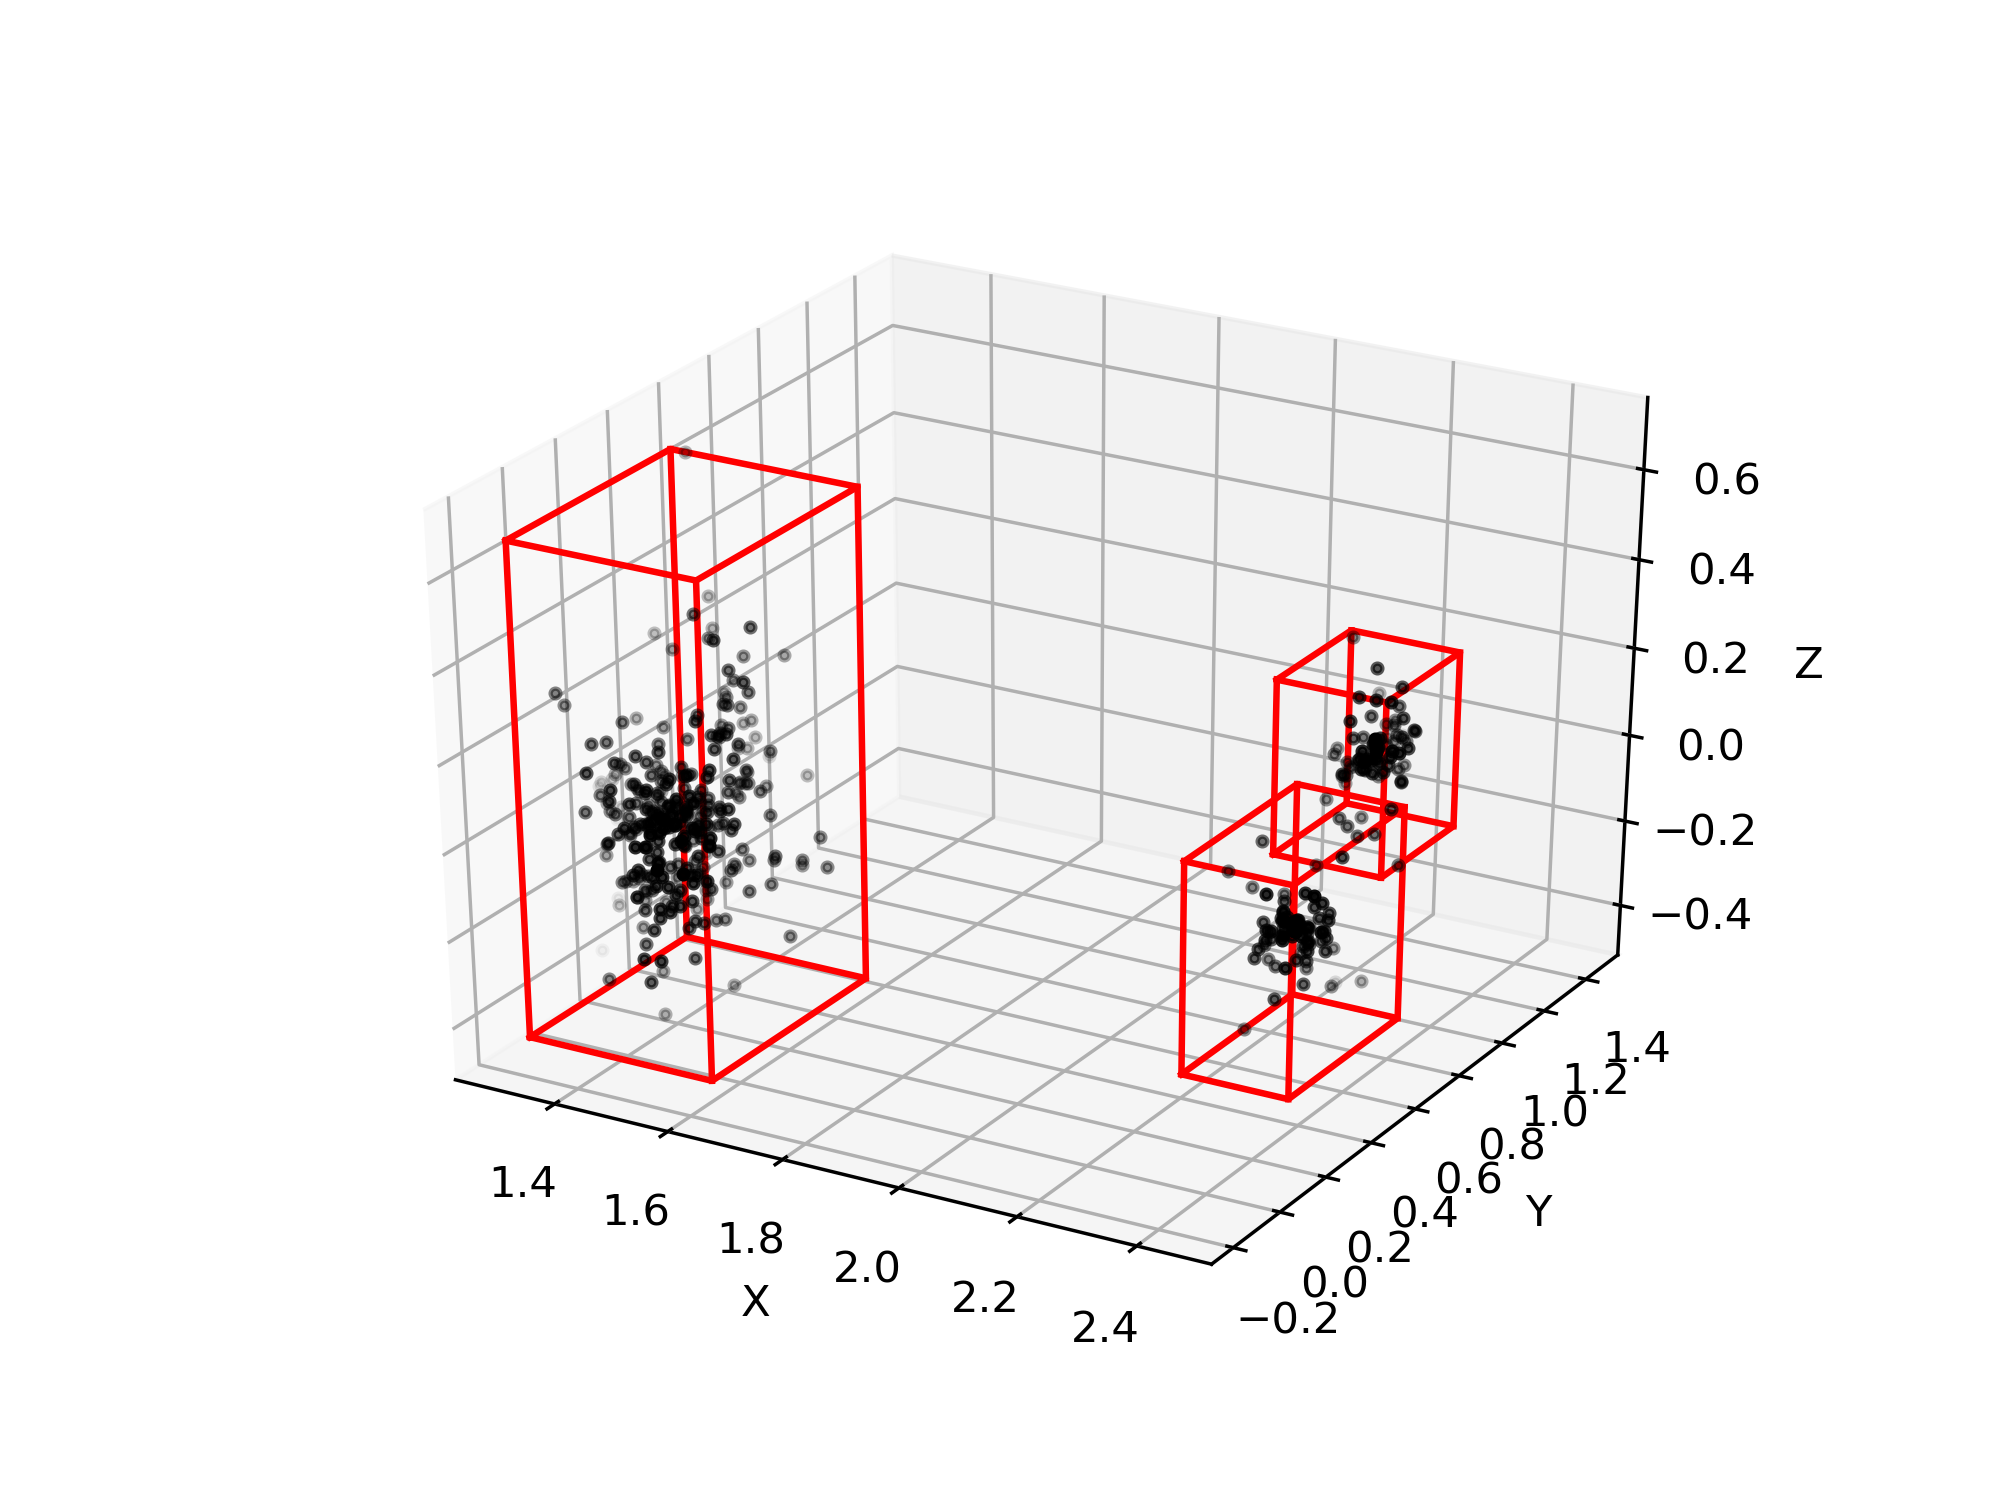

[2.08427734375, 2.2712890625, 1.10087890625, 1.43876953125, -0.2439453125, 0.1603515625, [2.1828510274960746, 1.2912380598917486, -0.04320282912165427]]
x=0.187	y=0.338	z=0.404
[2.2609579396802326, 2.4406454396802326, 0.24626408066860467, 0.7325922056686047, -0.3836641533430233, 0.10022256540697674, [2.3629199448436067, 0.4685904505122783, -0.10392500398912165]]
x=0.180	y=0.486	z=0.484
[1.3053644481689735, 1.6276300731689735, -0.17394706963667822, 0.4557404303633218, -0.43753784602076123, 0.6769152789792388, [1.4547426352352562, 0.11243765134741532, 0.010808542515896274]]
x=0.322	y=0.630	z=1.114


In [482]:
# i_list=list(np.linspace(0,1382,1383).astype(int))
i_list=list(np.linspace(1381,2753,1373).astype(int))
# i_list=list(np.linspace(2752,3919,1178).astype(int))

fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

# plot_data(ax,i_list,final)
# plot_data(ax,i_list_graph1[5],final,color="r")
# plot_data(ax,i_list_graph2[5],final,color="r")
# plot_data(ax,i_list_graph3_2[1],final,color="r")
plot_data(ax,i_list_graph1_check_func,final1)
verts = find_verts(i_list_graph1_check_func, final1)
plot_cube(ax, verts)
print(verts)
print("x=%.3f\ty=%.3f\tz=%.3f" %((verts[1]-verts[0]), (verts[3]-verts[2]), (verts[5]-verts[4])))
plot_data(ax,i_list_graph2_check_func,final2)
verts = find_verts(i_list_graph2_check_func, final2)
plot_cube(ax, verts)
print(verts)
print("x=%.3f\ty=%.3f\tz=%.3f" %((verts[1]-verts[0]), (verts[3]-verts[2]), (verts[5]-verts[4])))
plot_data(ax,i_list_graph3_check_func,final3)
verts = find_verts(i_list_graph3_check_func, final3)
plot_cube(ax, verts)
print(verts)
print("x=%.3f\ty=%.3f\tz=%.3f" %((verts[1]-verts[0]), (verts[3]-verts[2]), (verts[5]-verts[4])))
# plot_data(ax,i_list_graph3_check_func,final2,color="r")

# for cluster in figure_part:
#     if len(cluster)>2:
#         verts = find_verts(cluster, final2)
#         plot_cube(ax, verts)

# plot_traj(ax, int(frame_num_count/W))
# figure_size()

plt.show()
# fig.savefig("1.jpg", dpi = 300)

In [28]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
del colors['k']
del colors['w']

colors_by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in colors.items())
colors_names = []
for each in colors_by_hsv:
    if each[0][1]>=0.2:
        colors_names.append(each[1])

<IPython.core.display.Javascript object>


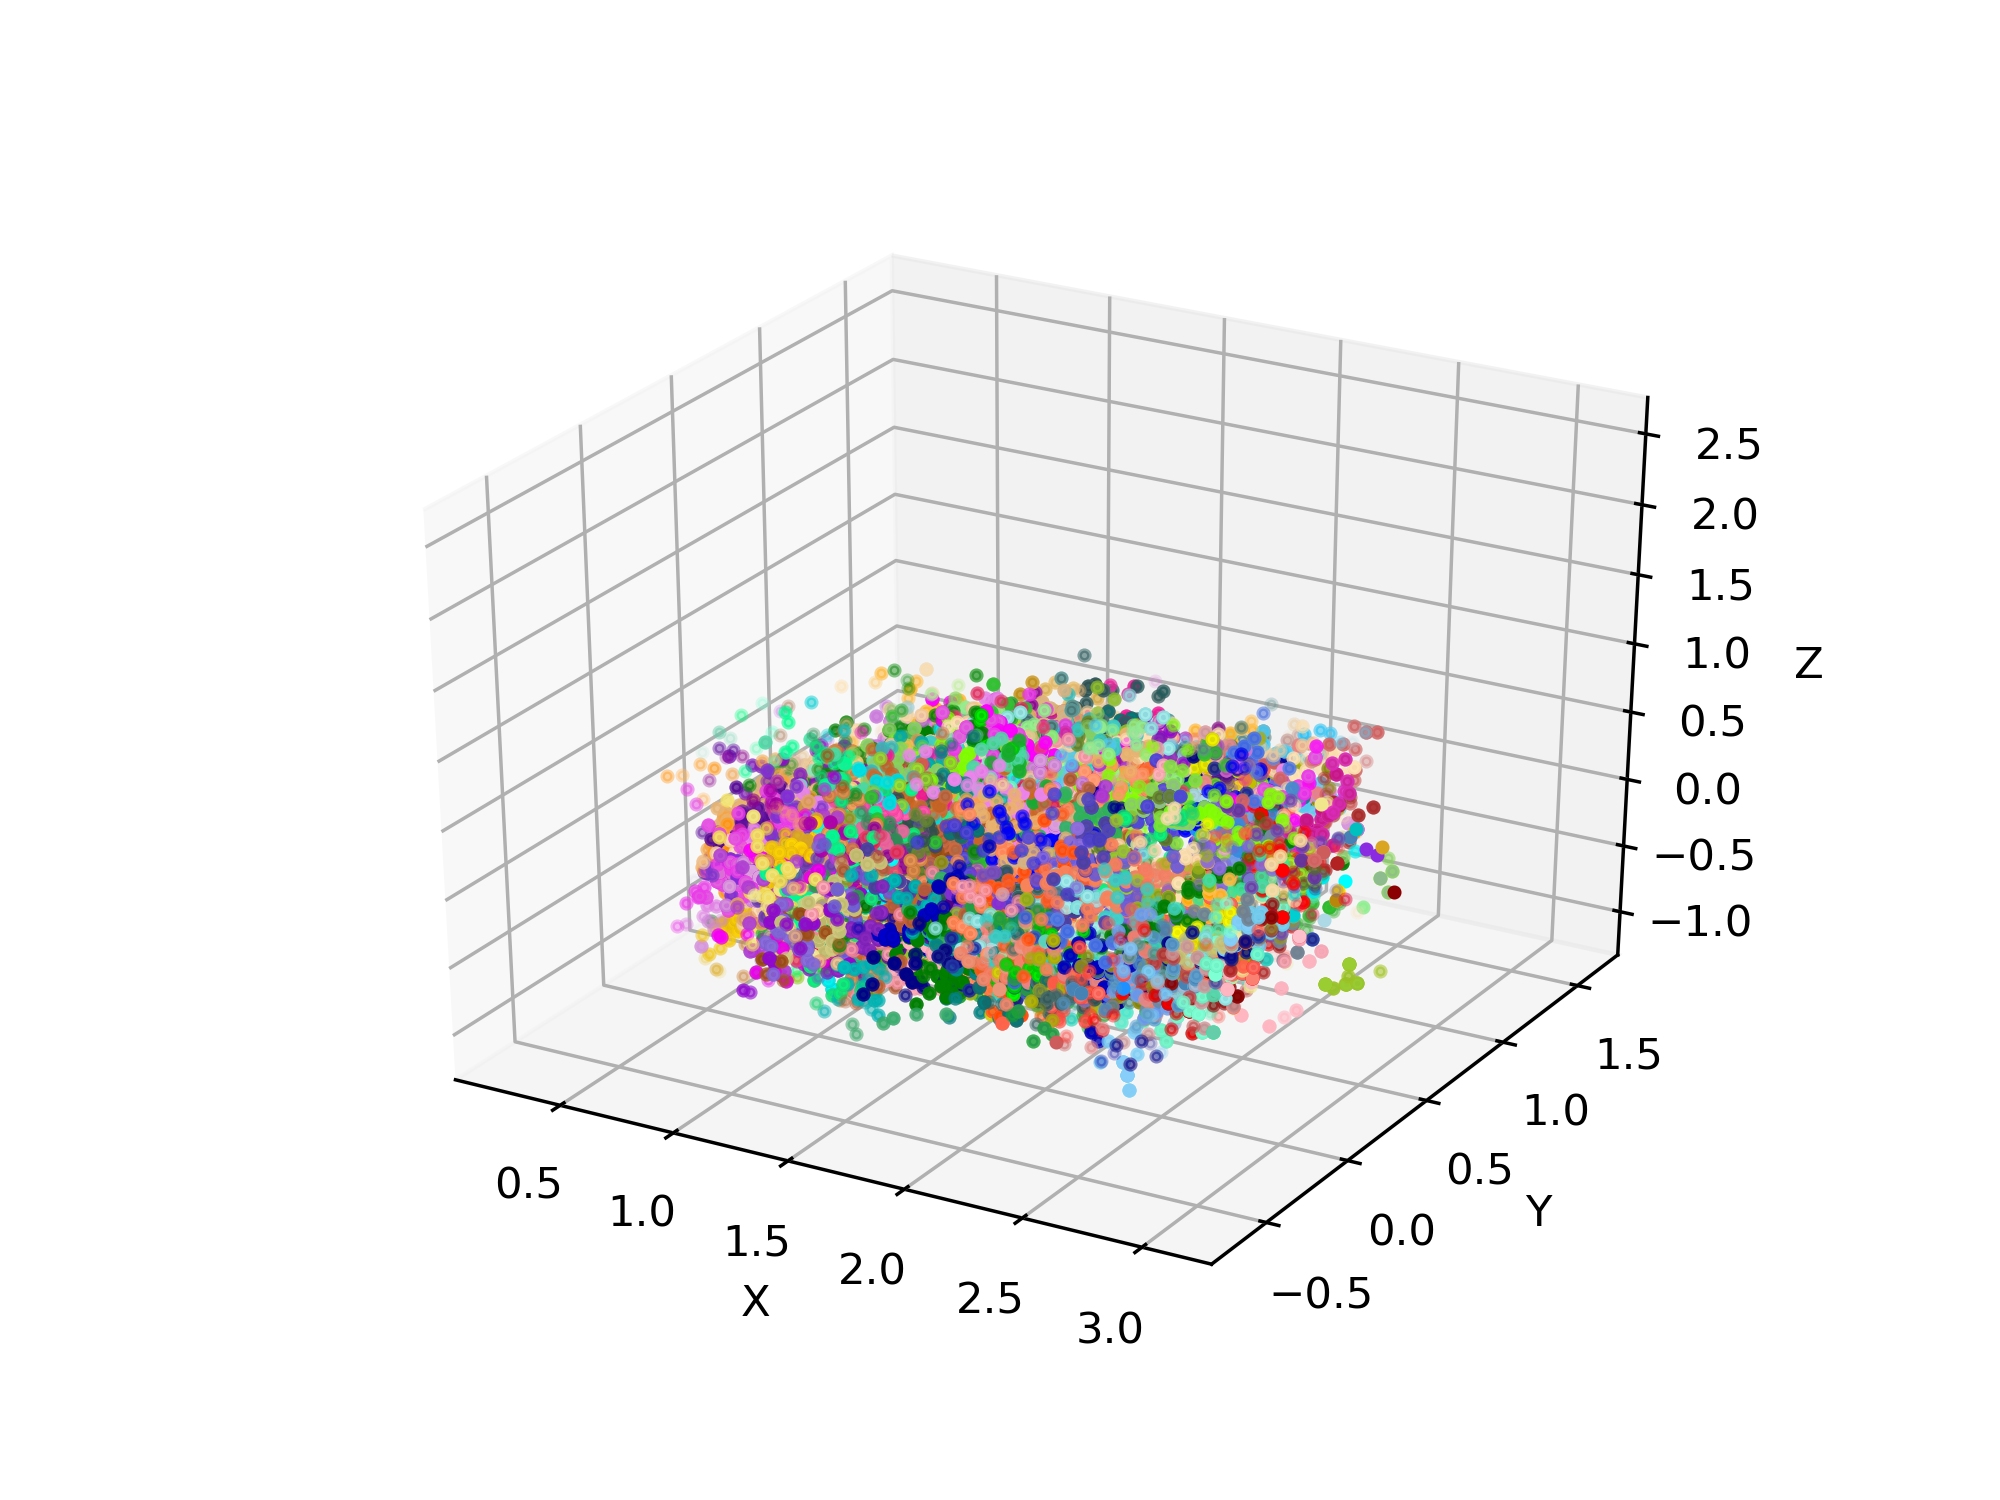

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


[None, None, None, None]

In [181]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

# i_list_all = dict()
for i in range(len(i_list_all)):
#     i_list = sort_data_graph(i*10, i*10+30, final)
    i_list = list(i_list_all[i*10])
    if i_list != []:
#     final2 = shift_data3(i_list, "center_xyorigin")
    # plot_data(ax, i_list, final, color = list(colors.keys())[i])
        plot_data(ax, i_list, final, color = colors_names[i%(len(colors_names))])
#     del i_list
#     del final2

plt.show()
[winsound.Beep(440,200) for _ in range(4)]

<IPython.core.display.Javascript object>


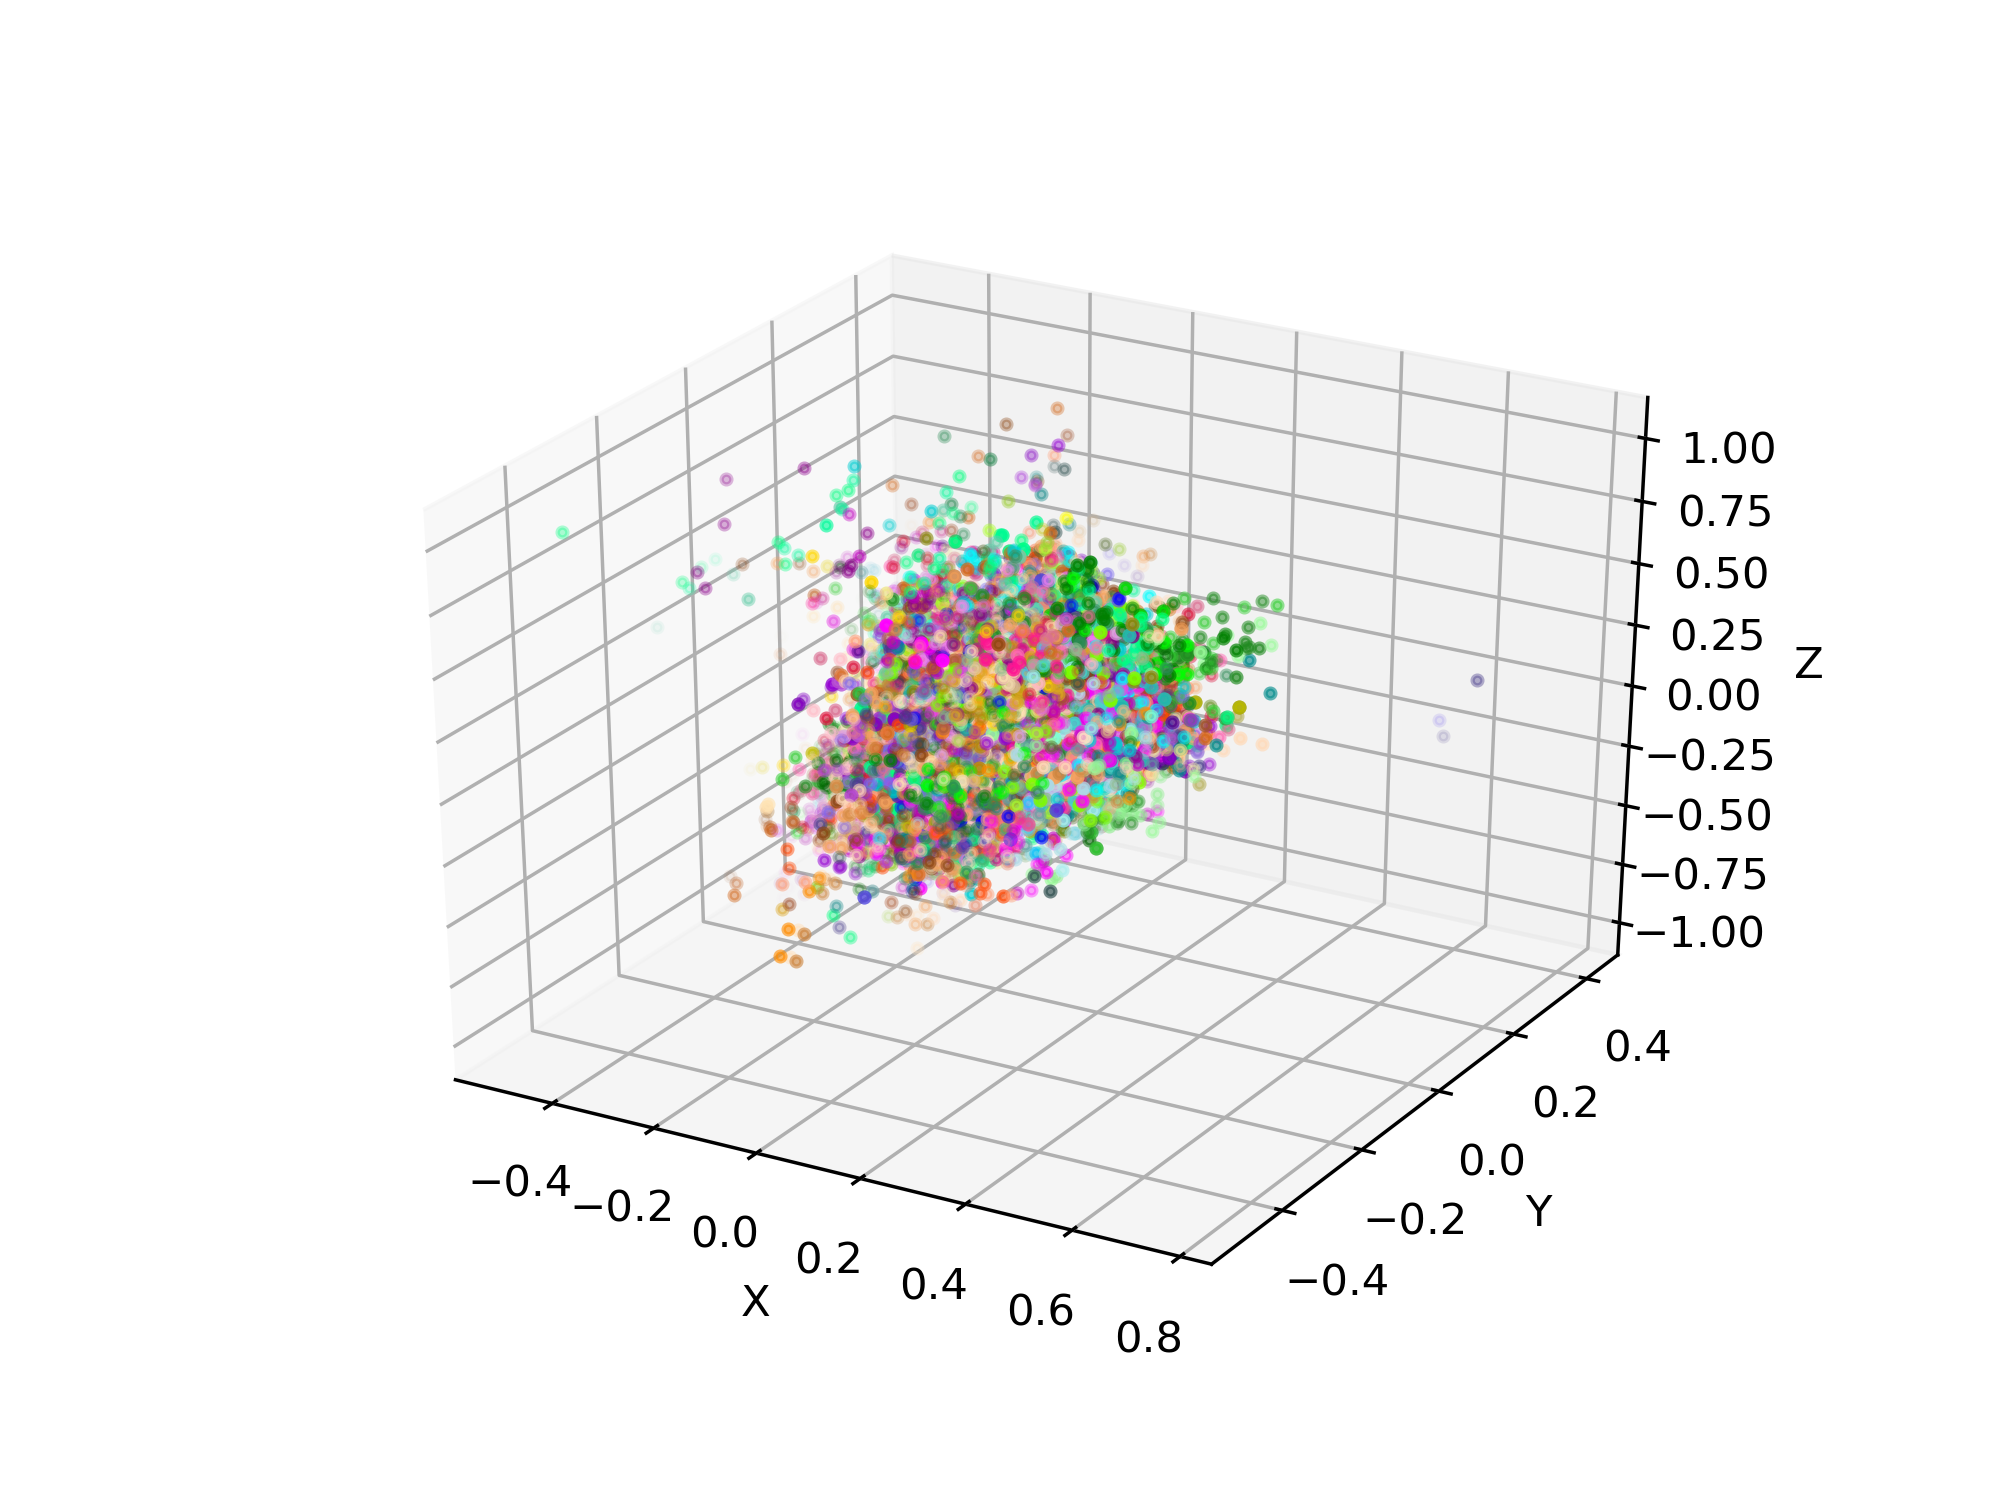

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys
G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys


[None, None, None, None]

In [182]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

for i in range(len(i_list_all)):
    i_list = i_list_all[i*10]
    if i_list != []:
        final2 = shift_data4(i_list, "frame_origin", 3)
        # plot_data(ax, i_list, final, color = list(colors.keys())[i])
        plot_data(ax, i_list, final2, color = colors_names[i%(len(colors_names))])
        del i_list
        del final2

plt.show()
[winsound.Beep(440,200) for _ in range(4)]

<IPython.core.display.Javascript object>


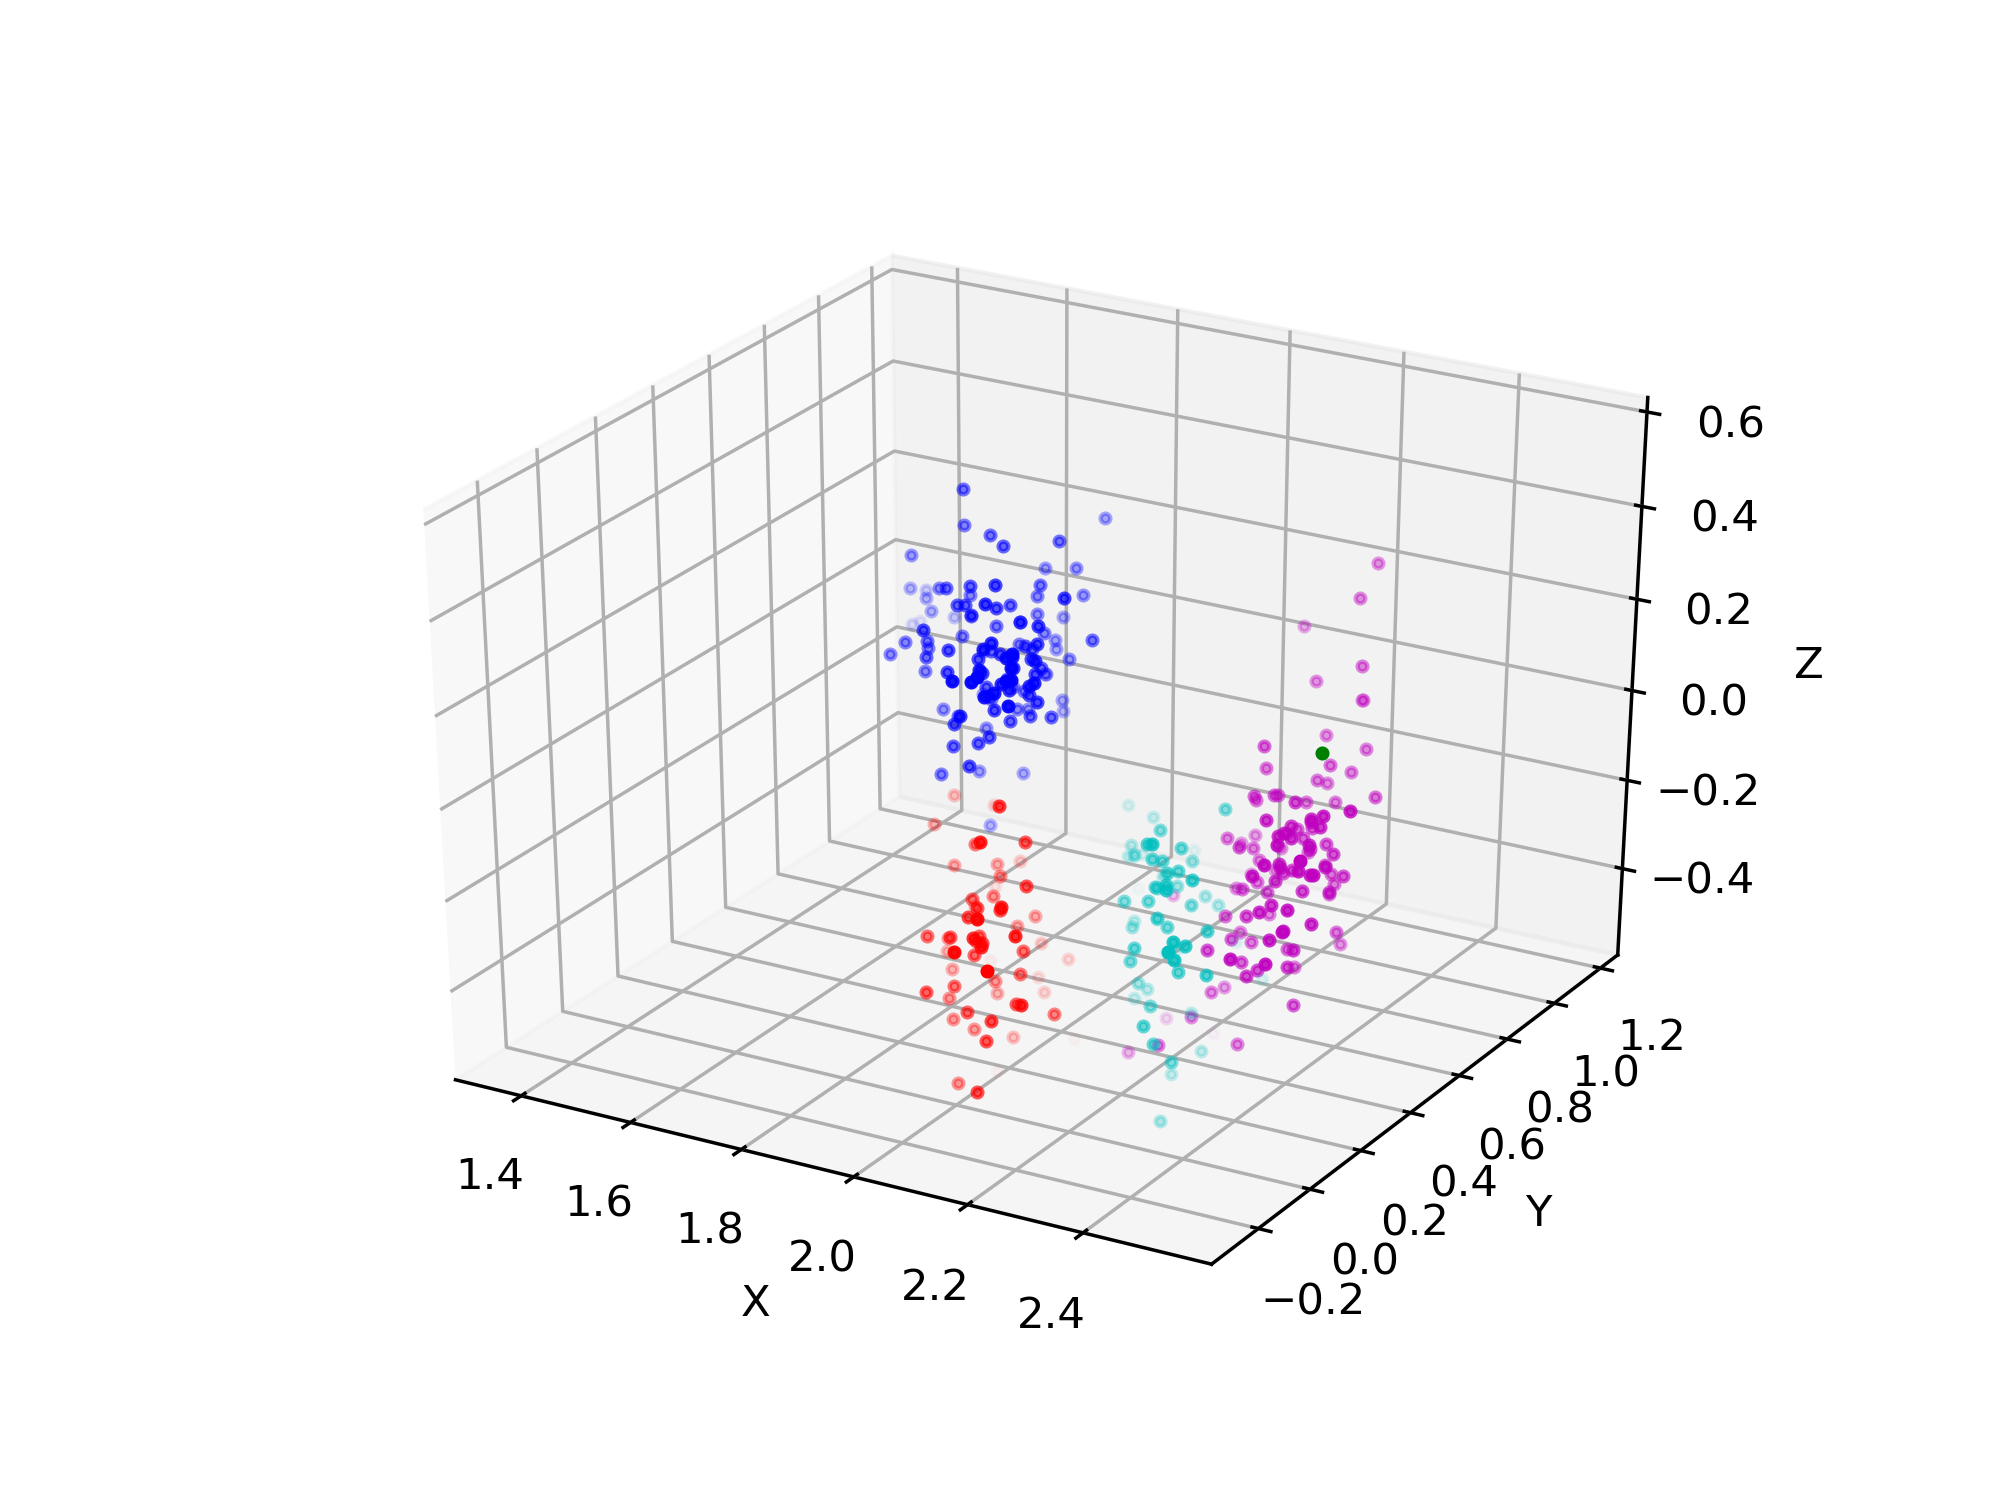

349


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


239
168
167
377


In [256]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

color_tmp=0
for i in list(np.argsort(np.array(i_list_count))[-5:]):
    print(i)
    i_list = i_list_all[i*10]
    if i_list != []:
        final2 = shift_data4(i_list, "frame_center", 3)
        plot_data(ax, i_list, final2, color = list(colors.keys())[color_tmp])
#         final3 = shift_data4(i_list, "center_xyorigin", 3)
#         plot_data(ax, i_list, final3, color = list(colors.keys())[1])
#         plot_data(ax, i_list, final, color = colors_names[i%(len(colors_names))])
        del i_list
#         del final2
    color_tmp+=1

plt.show()
# [winsound.Beep(440,200) for _ in range(4)]

<IPython.core.display.Javascript object>


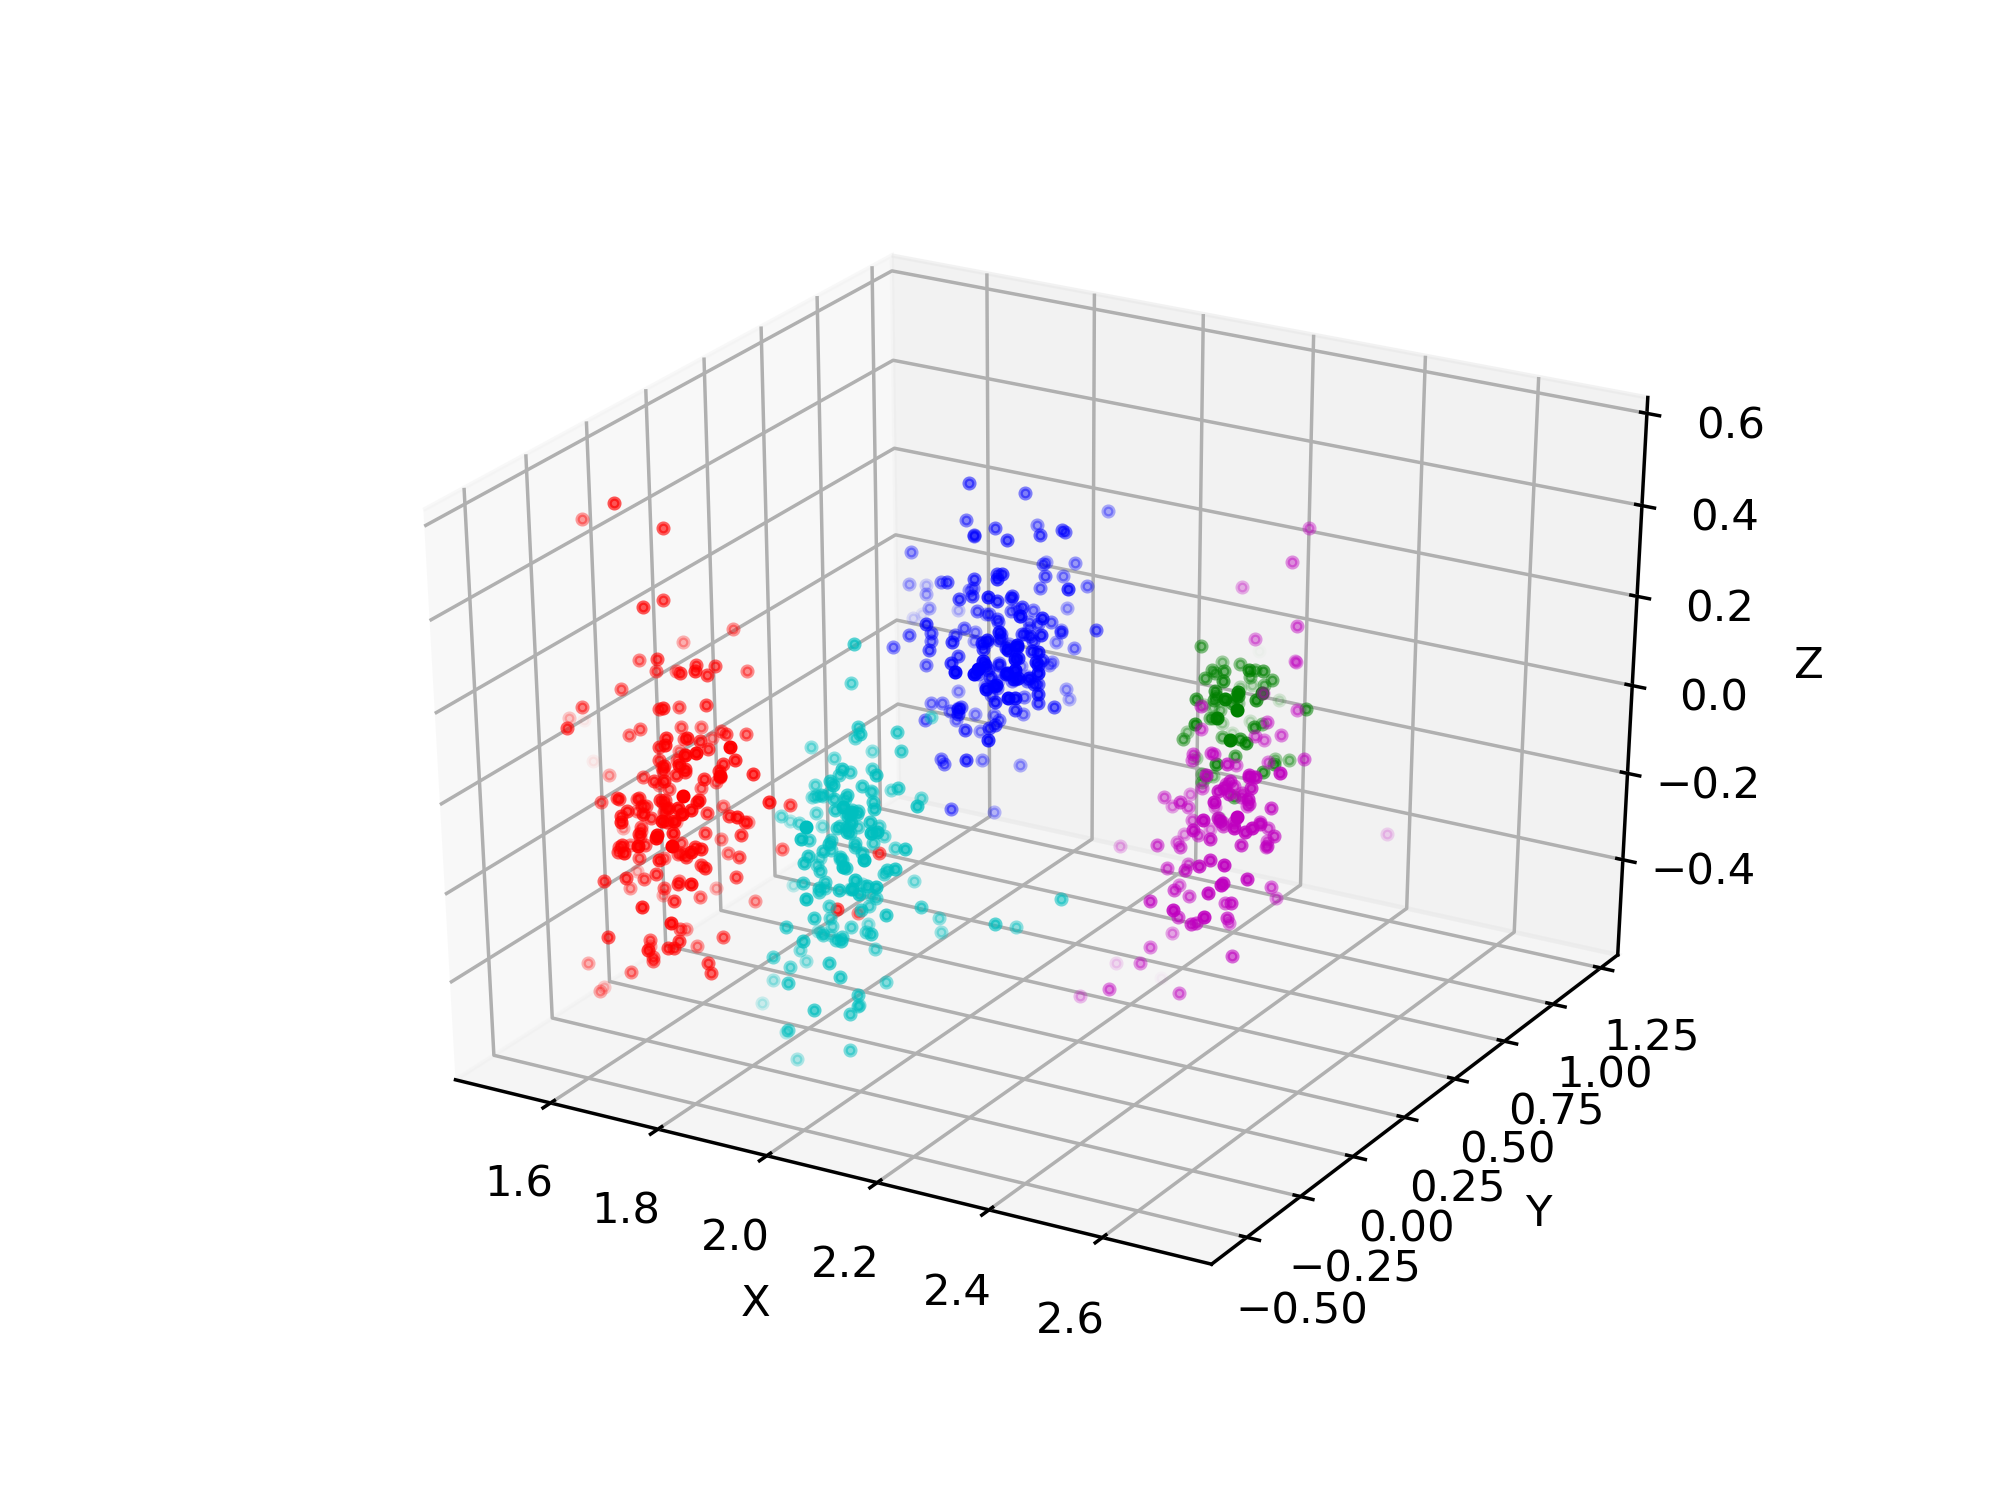

349


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


239
168
167
377


In [269]:
# Data from i_list_all_60frame
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

color_tmp=0
for i in list(np.argsort(np.array(i_list_count))[-5:]):
# for i in range(5):
    print(i)
    i_list = i_list_all_60frame[i*10]
    if i_list != []:
        final2 = shift_data4(i_list, "frame_center", 3)
        plot_data(ax, i_list, final2, color = list(colors.keys())[color_tmp])
#         final3 = shift_data4(i_list, "center_xyorigin", 3)
#         plot_data(ax, i_list, final3, color = list(colors.keys())[1])
#         plot_data(ax, i_list, final, color = colors_names[i%(len(colors_names))])
        del i_list
#         del final2
    color_tmp+=1

plt.show()
# [winsound.Beep(440,200) for _ in range(4)]

<IPython.core.display.Javascript object>


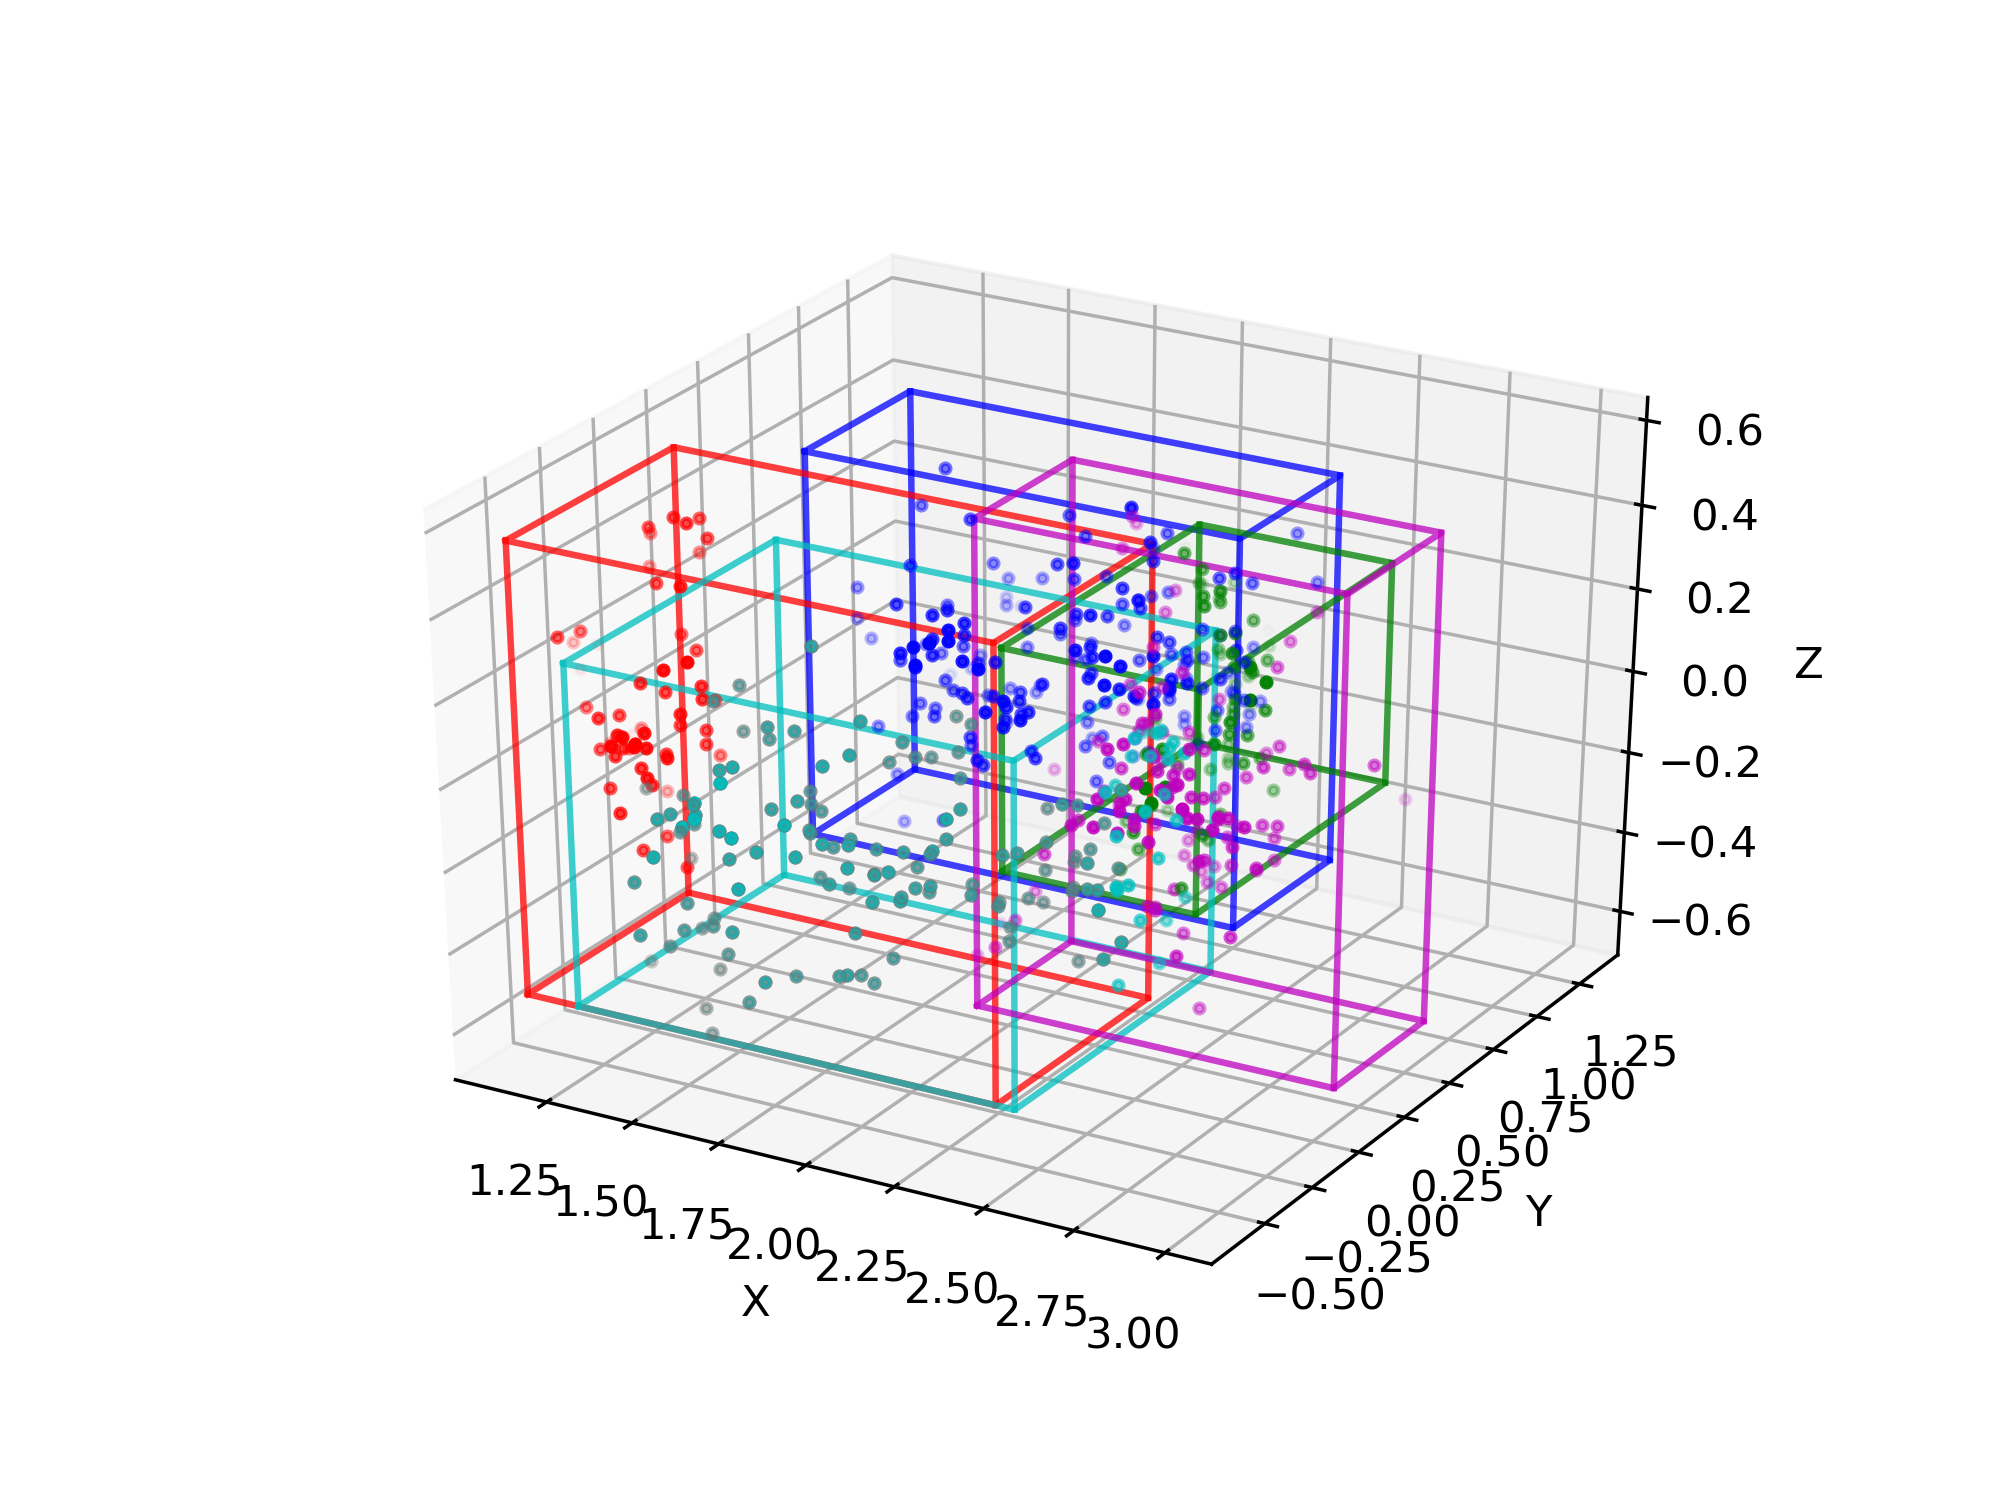

349


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


[1.138671875, 2.380859375, 0.748046875, 1.2890625, -0.552734375, 0.3984375, [1.7476868123086455, 1.0179837166785666, -0.07926580335718343]] 1.2421875 0.541015625 0.951171875
239


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


[1.9609375, 2.51171875, 0.291015625, 1.333984375, -0.345703125, 0.197265625, [2.222754297409327, 0.9161182669847729, -0.08721250739266381]] 0.55078125 1.04296875 0.54296875
168


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


[1.1171875, 2.455078125, -0.6328125, 0.150390625, -0.517578125, 0.56640625, [1.6708458038809972, -0.25256405548340005, -0.0689541648676813]] 1.337890625 0.783203125 1.083984375
167


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


[1.265625, 2.5078125, -0.6328125, 0.3828125, -0.517578125, 0.30859375, [1.9461591869072001, -0.1557456757646118, -0.148328717305223]] 1.2421875 1.015625 0.826171875
377


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


[1.978515625, 2.990234375, 0.126953125, 0.623046875, -0.625, 0.55078125, [2.4023255206821257, 0.39170361958364663, -0.11132902331482003]] 1.01171875 0.49609375 1.17578125


In [275]:
# Data from i_list_all_60frame
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

color_tmp=0
for i in list(np.argsort(np.array(i_list_count))[-5:]):
# for i in range(5):
    print(i)
    i_list = i_list_all_60frame[i*10]
    if i_list != []:
#         final2 = shift_data4(i_list, "frame_center", 3)
        plot_data(ax, i_list, final, color = list(colors.keys())[color_tmp])
        verts = find_verts(i_list, final)
        print(verts, verts[1]-verts[0], verts[3]-verts[2], verts[5]-verts[4])
        plot_cube(ax, verts, alpha=0.75, color=list(colors.keys())[color_tmp])
#         final3 = shift_data4(i_list, "center_xyorigin", 3)
#         plot_data(ax, i_list, final3, color = list(colors.keys())[1])
#         plot_data(ax, i_list, final, color = colors_names[i%(len(colors_names))])
        del i_list
#         del final2
    color_tmp+=1

plt.show()
# [winsound.Beep(440,200) for _ in range(4)]

In [281]:
for i_list in i_list_all_60frame.values():
    i_list=list(i_list)
    print(intensity_total(i_list),find_verts(i_list,final)[-1])

43.02680671210805 [2.1730087819304664, 1.2970980318572234, -0.032819340121483714]
27.660090029207993 [2.3293716671350904, 1.2190542344349407, 0.00831298791918146]
13.522710680939998 [2.4558699539790765, 1.076063199343822, 0.00574879500143757]
1.844006001948 [2.5130169299657537, 0.9058897446963623, -0.03951317042349091]
-6.146686673159999 [2.527520384164959, 0.7062260783017604, -0.01257063139731617]
-23.972078025315994 [2.4466822324895388, 0.5805930555312817, -0.08819657360606709]
-38.109457373584014 [2.3629199448436067, 0.46859045051227843, -0.10392500398912166]
-51.017499387220084 [2.255969345517303, 0.36741574980275143, -0.10009969129955194]
-74.3749087452281 [2.0781946023820543, 0.2310467024651824, -0.11745204344226089]
-95.27364343397198 [1.96846763705341, 0.17596078593567965, -0.11065671428799366]
-117.40171545734783 [1.8171451035343176, 0.12944899816251434, -0.06476252811279949]
-143.21779948462802 [1.61811263208289, 0.11019392099166601, -0.01767113915410295]
-172.1072268484805 [

107.56701678023998 [1.4214834954947835, -0.14869472099236664, -0.09156988552717182]
70.07222807400612 [1.4749412903821855, -0.041354214103809316, -0.1040292836581843]
57.77885472770013 [1.555111215497151, 0.18946663704706812, -0.14246841337854513]
53.476174056488105 [1.6890866299383491, 0.4296899792634915, -0.1444041772662916]
59.008192062332135 [1.7736510829131726, 0.5660600293208008, -0.12353040910590864]
56.549517393068115 [1.8746996351166791, 0.6927996188769968, -0.08787652501137823]
36.880120038956015 [2.026103066350299, 0.8539819417262885, -0.0746226496904529]
27.660090029219994 [2.0910886870019056, 0.9259626137667333, -0.07078915464842028]
18.440060019479997 [2.148356126954124, 1.0087402075236651, -0.0944994290526447]
7.990692675107998 [2.175027214764174, 1.1139197775852616, -0.04615324263329703]
7.376024007780001 [2.7690828120085893, 0.9620350149229117, -0.18714385626005406]
-17.825391352163997 [2.5521507273897956, 0.5489180903544879, -0.13862863404369807]
-28.274758696535994 [

94.04430609934597 [1.770711456600053, 0.9683000679962868, -0.07592816195550023]
66.99888473744215 [1.9128082750274131, 0.9924206649438099, -0.09771809218775807]
43.02680671211805 [2.101827715131146, 0.9568291135793557, -0.10166311217949582]
35.65078270432601 [2.207058008330594, 0.9311194853529775, -0.09732214256228403]
23.972078025323995 [2.3014420181264827, 0.9081031928608275, -0.07790456190972966]
11.678704679003998 [2.364829100016897, 0.8766136904688522, -0.054028554403288784]
-1.844006001948 [2.786356613953883, 0.19818029973983775, -0.0693792301263978]
-11.678704679003998 [2.7213340854502848, 0.09940270558571769, -0.10552349606147175]
-15.981385350215996 [2.6537738664181596, 0.033126943508454354, -0.1285696943842041]
-39.33879470820402 [2.573529762196792, -0.12271050999473565, -0.14421057486782693]
-39.33879470820402 [2.5595873491975345, -0.12196276176762672, -0.14049326684264368]
-39.33879470820402 [2.5173423513196105, -0.09382299862911969, -0.15525963692230255]
-36.26545137162401

-84.82427620879804 [2.178778711441633, 0.38650246873600935, -0.06469770799769387]
-118.631052911164 [2.02132020019209, 0.34406447885619024, -0.07067024019580333]
-151.20849227888823 [1.81650047761729, 0.2569073983556004, -0.08816384301949083]
-178.25391364079226 [1.6679950591370645, 0.21308043523462714, -0.04414779106442193]
-164.1165342925246 [1.4746291936209388, 0.19774377330776827, -0.007226896834613869]
-143.2177994845781 [1.32884636612509, 0.2125480465942006, -0.007686337707525912]
-88.51228809346999 [1.1979493605608424, 0.2714586716089171, -0.009063498930451462]
-22.12807202336 [1.1300065097698895, 0.3514888636754502, 0.00434813882479074]
47.94415605063807 [1.0895150451718651, 0.4602983139777936, 0.03455761707796851]
110.02569144955389 [1.122056266017886, 0.5882154903138065, 0.005470034903505299]
133.38310080756187 [1.1889661794523794, 0.7325315986857521, -0.020843268294339]
147.52048015583014 [1.2873145893834754, 0.848575394600771, -0.012515866069776005]
141.37379348267402 [1.48

In [309]:
def plot_octree(ax, i_list, data_list, alpha = 1, color = 'r'):
    verts = find_verts(i_list, data_list)
    x_min, x_max, y_min, y_max, z_min, z_max, center = verts
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    z_mid = (z_min + z_max) / 2

    oct_list = {}
    for i in range(8):
        oct_list[i] = []
    for point in i_list:
        if data_list[point, 1]<x_mid and data_list[point, 2]<y_mid and data_list[point, 3]<z_mid:
            oct_list[0].append(point)
        elif data_list[point, 1]<x_mid and data_list[point, 2]<y_mid and data_list[point, 3]>z_mid:
            oct_list[1].append(point)
        elif data_list[point, 1]<x_mid and data_list[point, 2]>y_mid and data_list[point, 3]<z_mid:
            oct_list[2].append(point)
        elif data_list[point, 1]<x_mid and data_list[point, 2]>y_mid and data_list[point, 3]>z_mid:
            oct_list[3].append(point)
        elif data_list[point, 1]>x_mid and data_list[point, 2]<y_mid and data_list[point, 3]<z_mid:
            oct_list[4].append(point)
        elif data_list[point, 1]>x_mid and data_list[point, 2]<y_mid and data_list[point, 3]>z_mid:
            oct_list[5].append(point)
        elif data_list[point, 1]>x_mid and data_list[point, 2]>y_mid and data_list[point, 3]<z_mid:
            oct_list[6].append(point)
        elif data_list[point, 1]>x_mid and data_list[point, 2]>y_mid and data_list[point, 3]>z_mid:
            oct_list[7].append(point)
    
    verts = [[x_min,x_mid,x_max],[y_min,y_mid,y_max],[z_min,z_mid,z_max]]
    if len(oct_list[0]) > 0:
        plot_cube(ax, [verts[0][0],verts[0][1],verts[1][0],verts[1][1],verts[2][0],verts[2][1],center])
    if len(oct_list[1]) > 0:
        plot_cube(ax, [verts[0][0],verts[0][1],verts[1][0],verts[1][1],verts[2][1],verts[2][2],center])
    if len(oct_list[2]) > 0:
        plot_cube(ax, [verts[0][0],verts[0][1],verts[1][1],verts[1][2],verts[2][0],verts[2][1],center])
    if len(oct_list[3]) > 0:
        plot_cube(ax, [verts[0][0],verts[0][1],verts[1][1],verts[1][2],verts[2][1],verts[2][2],center])
    if len(oct_list[4]) > 0:
        plot_cube(ax, [verts[0][1],verts[0][2],verts[1][0],verts[1][1],verts[2][0],verts[2][1],center])
    if len(oct_list[5]) > 0:
        plot_cube(ax, [verts[0][1],verts[0][2],verts[1][0],verts[1][1],verts[2][1],verts[2][2],center])
    if len(oct_list[6]) > 0:
        plot_cube(ax, [verts[0][1],verts[0][2],verts[1][1],verts[1][2],verts[2][0],verts[2][1],center])
    if len(oct_list[7]) > 0:
        plot_cube(ax, [verts[0][1],verts[0][2],verts[1][1],verts[1][2],verts[2][1],verts[2][2],center])

    return oct_list

<IPython.core.display.Javascript object>


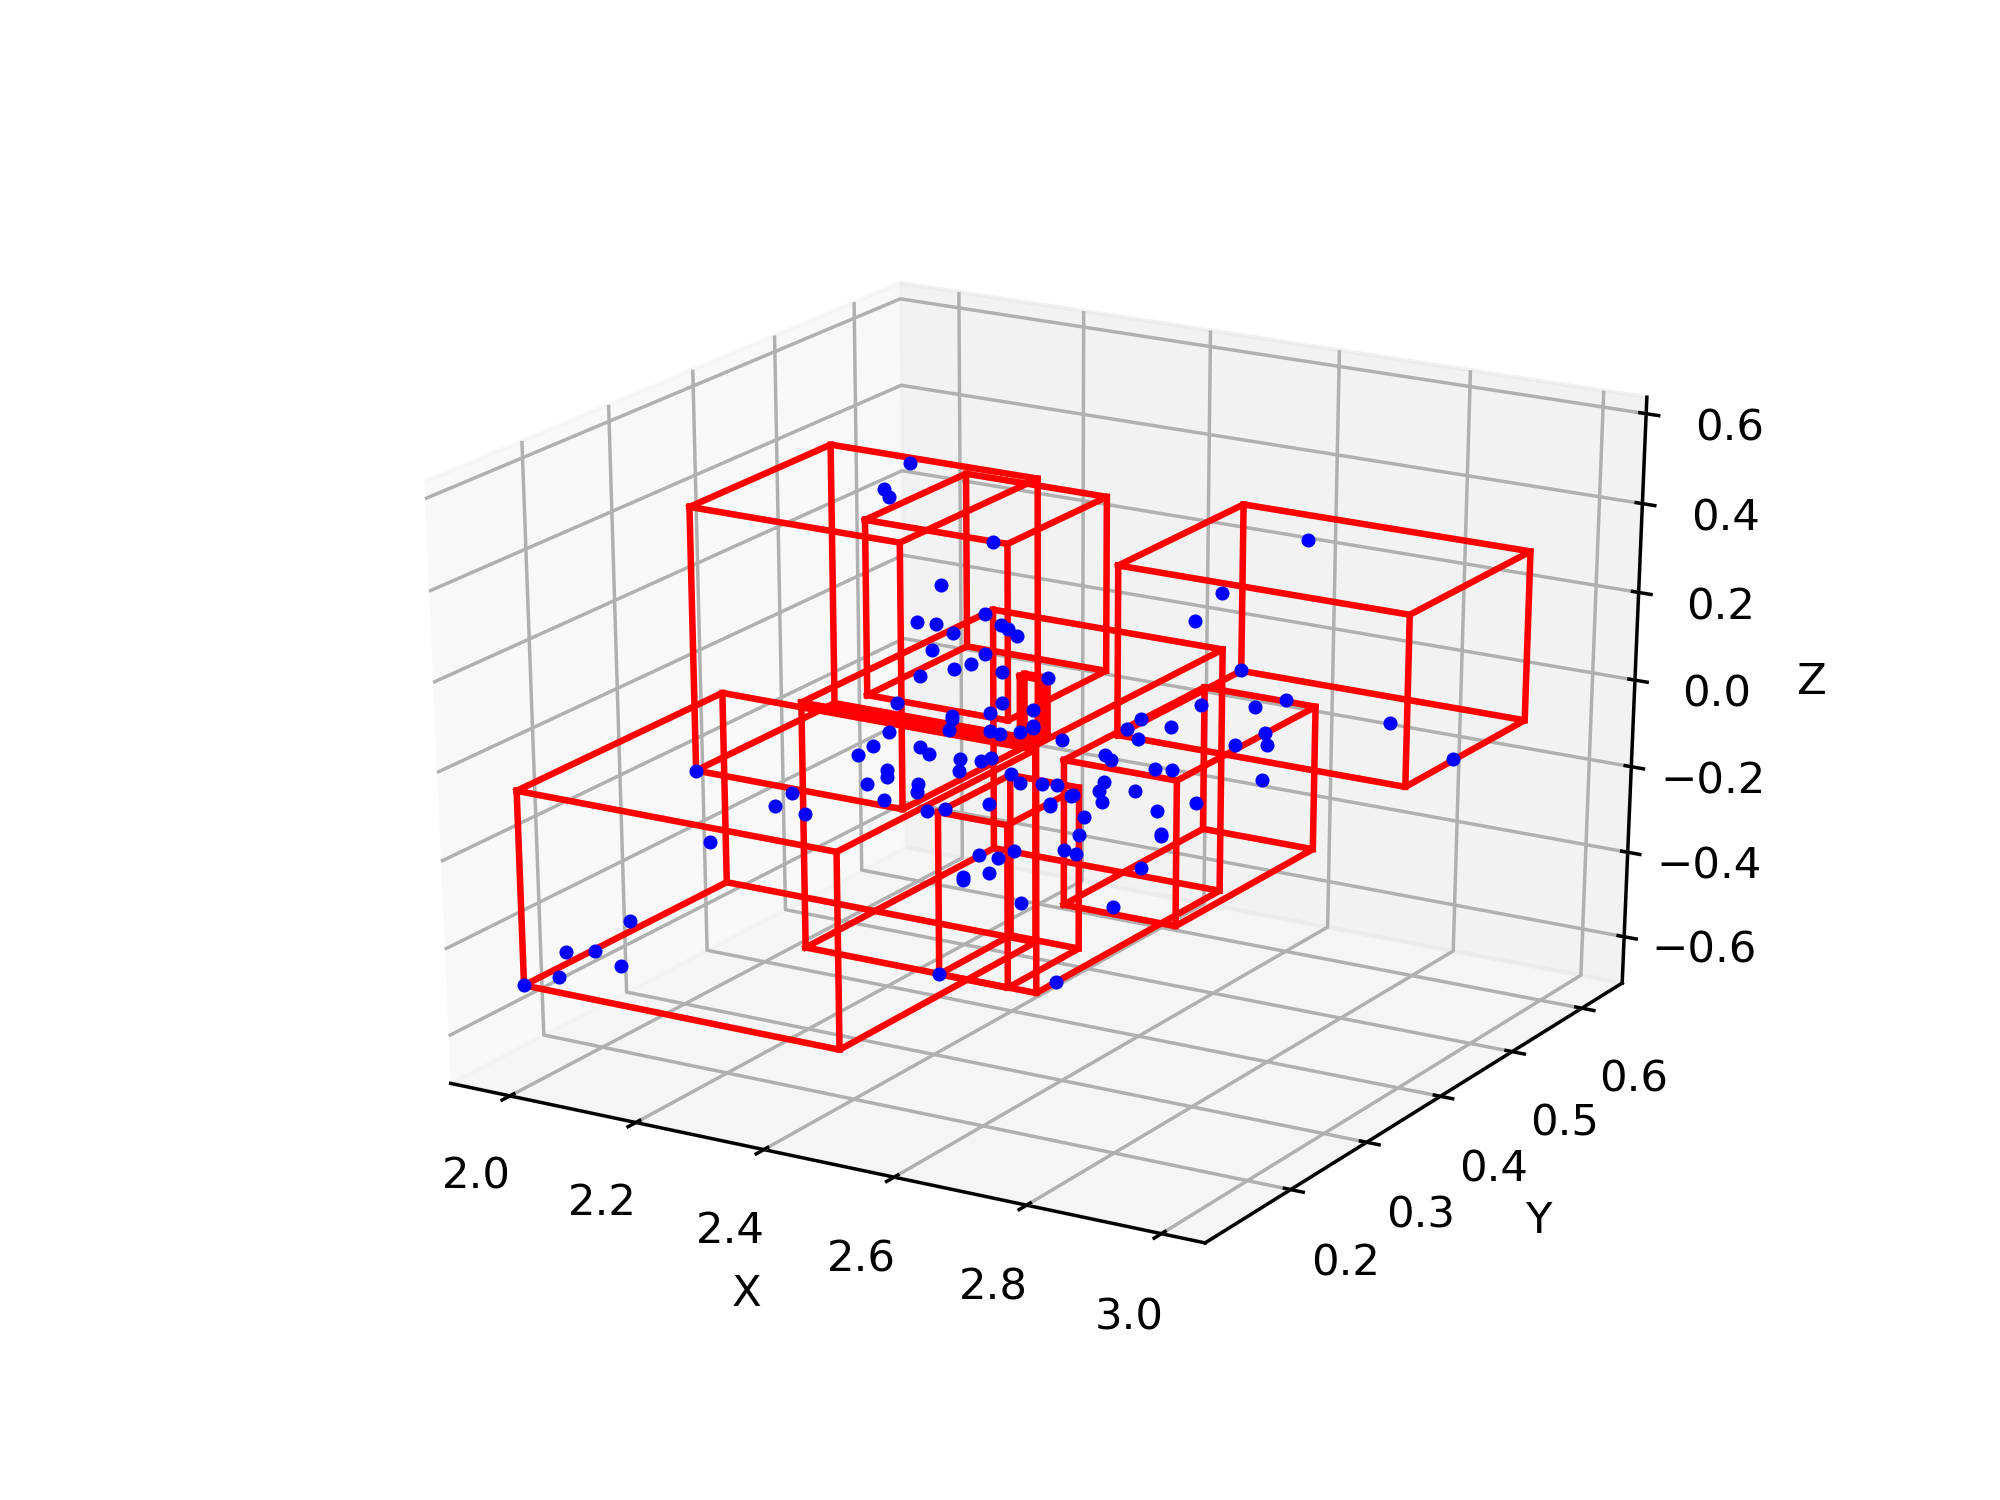

[1.978515625, 2.990234375, 0.126953125, 0.623046875, -0.625, 0.55078125, [2.4023255206821257, 0.39170361958364663, -0.11132902331482003]]
{0: [85960, 85963, 85964, 85965, 85992, 85993, 85994, 86022, 86045, 86046, 86047, 86048, 86071, 86072, 86073, 86123, 86124, 86150, 86151, 86152, 86249, 86273, 86274], 1: [86020, 86021, 86050, 86074, 86075, 86100, 86127, 86175, 86222, 86223, 86224, 86225, 86275, 86299], 2: [86453, 85961, 85962, 86475, 86479, 85988, 86501, 85989, 85990, 86099, 86125, 86126, 86153, 86176, 86198, 86199, 86200, 86247, 86248, 86323, 86324, 86325, 86349, 86350, 86399, 86400, 86401, 86426, 86427], 3: [85991, 86018, 86019, 86049, 86097, 86098, 86101, 86174, 86246, 86298], 4: [86300, 86351, 86352, 86375, 86376, 86377, 86403, 86404], 5: [86276, 86277], 6: [86476, 86477, 86502, 86551, 86574, 86605, 86606, 86250, 86326, 86327, 86402, 86428, 86429, 86430, 86431], 7: [86478, 86503, 86505, 86504, 86527, 86528, 86550, 87116, 86619, 86620, 86621, 86776]}


In [308]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

i_list = i_list_all_60frame[3770]
# final2 = shift_data4(i_list, "frame_xyorigin", 3)
plot_data(ax, i_list, final, color = 'b', index=1)
verts = find_verts(i_list, final)
print(verts)
# plot_cube(ax, verts)
plot_octree(ax, i_list, final)
plt.show()
# [winsound.Beep(440,200) for _ in range(4)]

In [ ]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

plot_data(ax,i_list_all[0],final)
plt.show()

In [267]:
i_list_all_60frame

{0: array([  19,   20,   21,  547,  548,  549,  550,  551,   43,   44,   45,
          46,   47,  573,  574,  575,  598,  599,  600,   91,   92,   93,
         116,  117,  118, 1161,  141,  142,  143,  154,  155,  156,  169,
         170,  688, 1206, 1207, 1208, 1209,  203,  216,  217,  218, 1255,
         241,  242,  243,  265,  266,  267,  290,  291,  292,  293, 1321,
        1322,  841,  842,  337,  865,  380,  381,  382,  404,  405,  406,
         428,  429,  430,  952,  454,  455,  456,  986,  987,  479,  480,
         481]),
 10: array([ 380,  381,  382, 1412, 1161,  265,  267,  266,  404,  405,  406,
        1567, 1568,  290,  291,  547,  292,  548,  293,  549, 1321,  551,
         550, 1322,  428,  429,  430,  688, 1206, 1207, 1208, 1209,  952,
        1591,  573,  574,  575, 1478, 1479,  454,  455,  456,  841,  842,
         337,  598,  599,  600,  986,  987, 1501, 1502,  479,  480,  865,
         481, 1255, 1389, 1390]),
 20: array([1637, 1638, 1255, 1639, 1389, 1390, 1412, 1

<IPython.core.display.Javascript object>


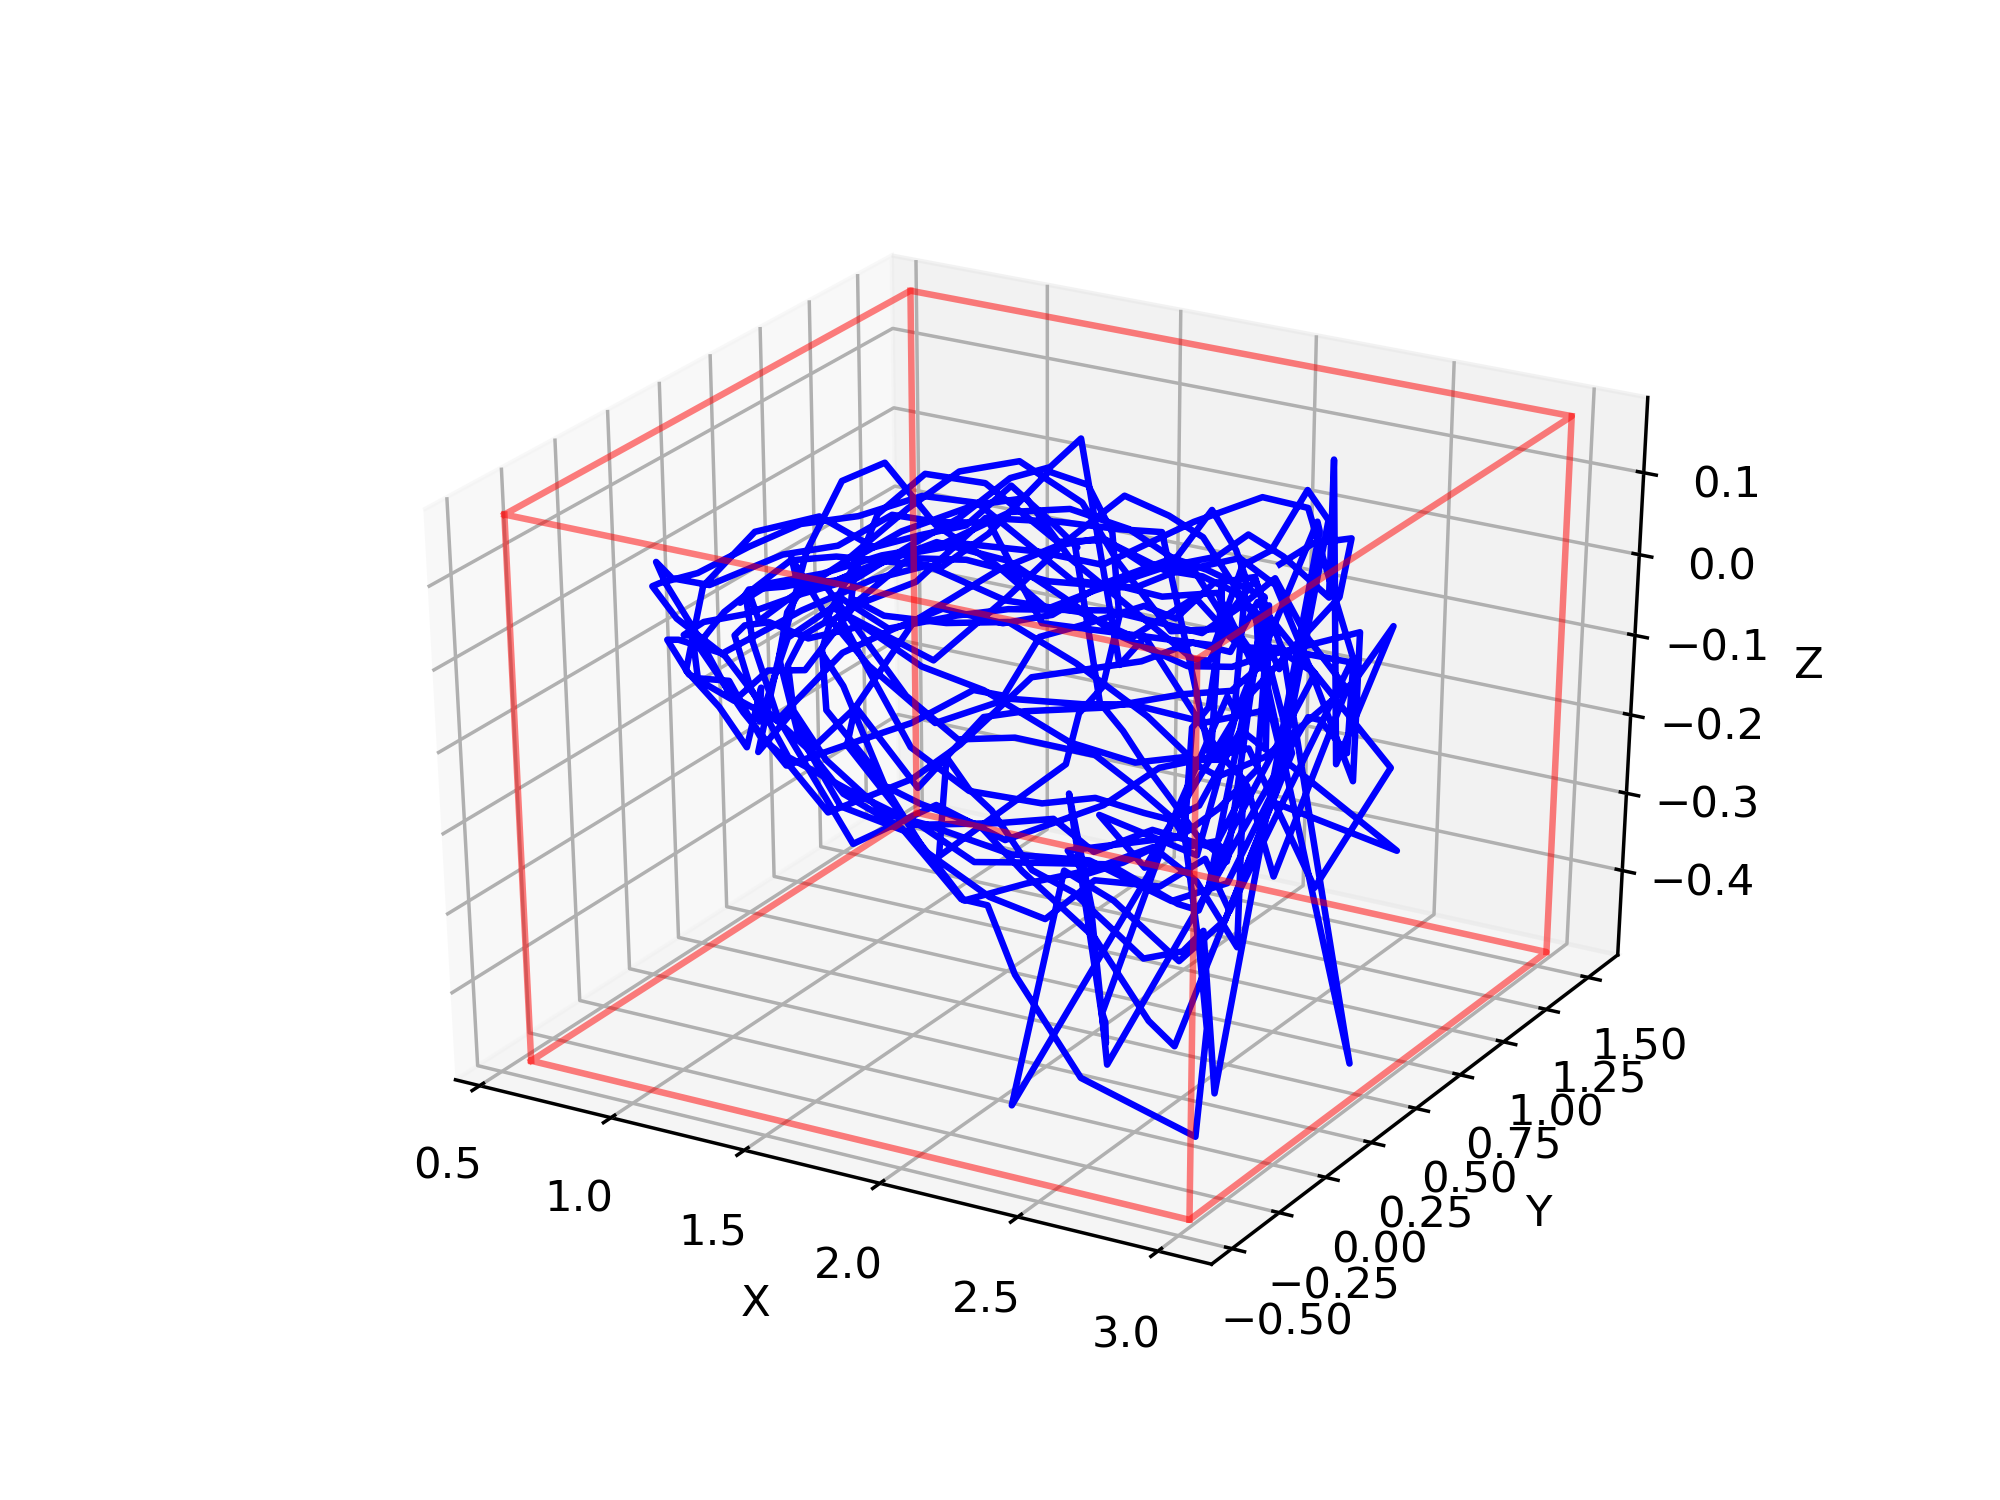

effective rate 490 533 0.9193245778611632
[0.5838700185978593, 3.0119945290515324, -0.46094586892092265, 1.5336107133547638, -0.49689493266277185, 0.1765457023281586]


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':
G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [175]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

plot_traj(ax,len(i_list_all),i_list_all)

plt.show()
# [winsound.Beep(440,200) for _ in range(4)]

<IPython.core.display.Javascript object>


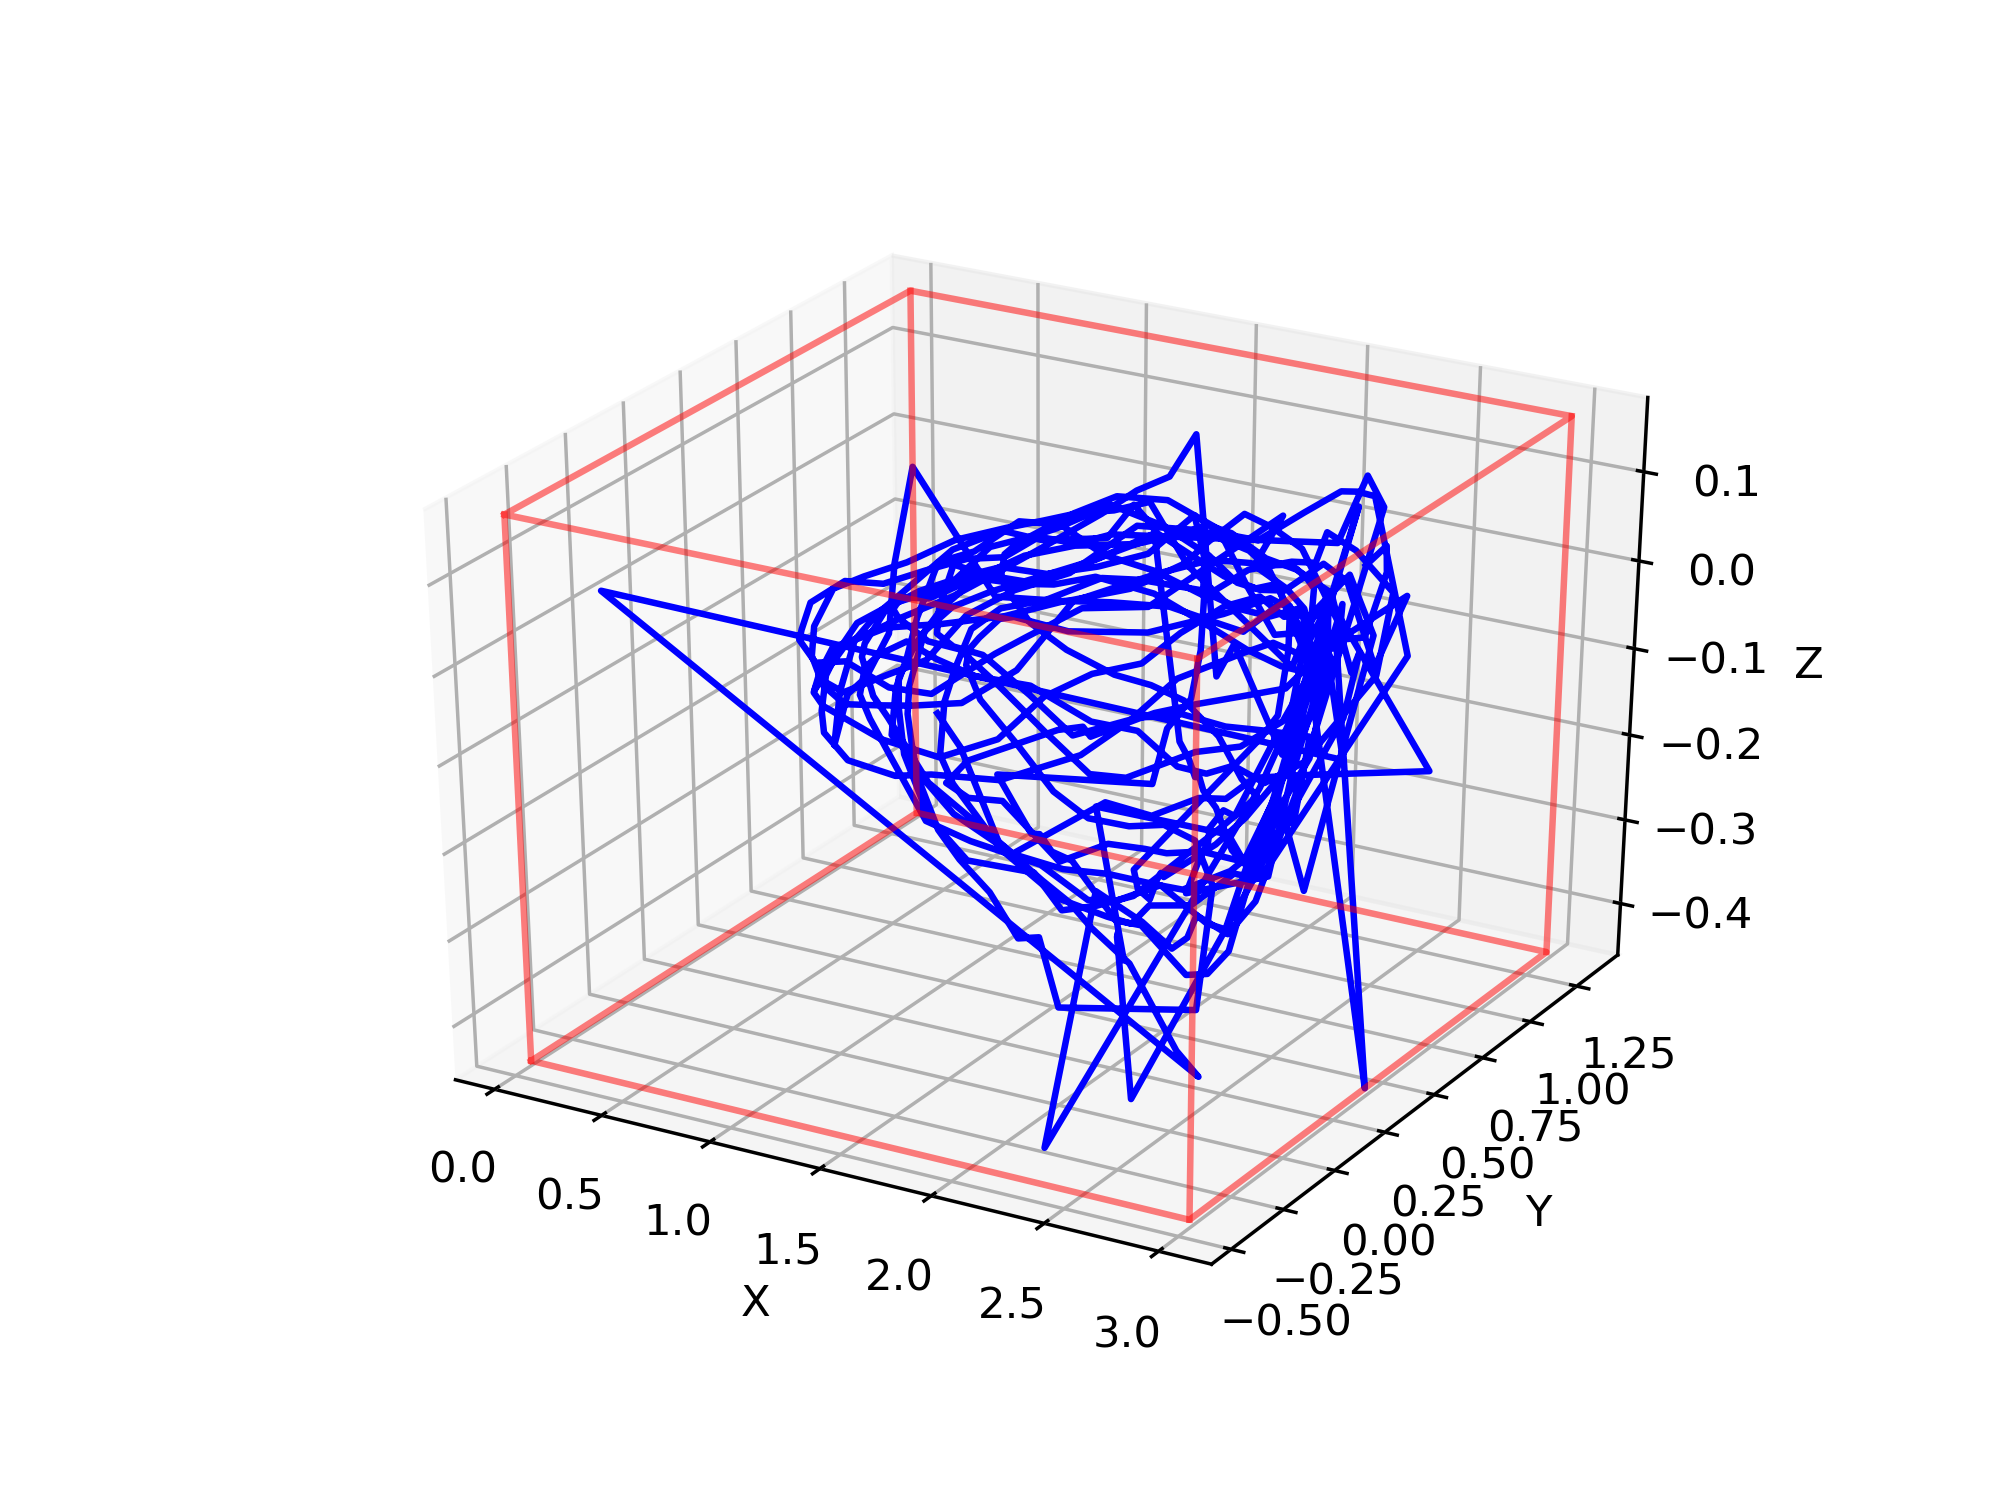

effective rate 529 530 0.9981132075471698
[0.03296908422540342, 3.0119945290515324, -0.46094586892092265, 1.3421831037064307, -0.4493737536034873, 0.16925200804602547]


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':
G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [284]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

plot_traj(ax,len(i_list_all_60frame),i_list_all_60frame)
# plot_traj(ax,10,i_list_all_60frame)

plt.show()
# [winsound.Beep(440,200) for _ in range(4)]

In [ ]:
# Compute i_list from all 5358 data from "sample_walk_1.txt" and save to "i_list_sample_walk_1.npy"

i_list_all_30frame = dict()
for i in range(int(np.floor((frame_num_count-20)/10))):
    i_list = sort_data_graph(i*10, i*10+30, final)
    i_list_all_30frame[i*10] = i_list

    np.save("i_list_sample_walk_1_30frame.npy", i_list_all_30frame)
    del i_list

# Retrieve saved i_list:
# np.load("i_list_sample_walk_1.npy", allow_pickle = "TRUE").item()

In [194]:
i_count=[]
for i_list in i_list_all.values():
    i_count += list(i_list)
len(i_count)

45640

In [172]:
# Figure estimation after shift to frame_origin using 30-frame sample with frame_patch_num = 3

x_shift = []
y_shift = []
z_shift = []
for i_list in i_list_all.values():
    i_list = list(i_list)
    if i_list != []:
        final2 = shift_data4(i_list, "frame_origin", 3)
        for each_point in i_list:
            x_shift.append(final2[each_point][1])
            y_shift.append(final2[each_point][2])
            z_shift.append(final2[each_point][3])

# print("patch_num: "+str(patch))
print("x: "+str(np.min(x_shift))+"\t"+str(np.max(x_shift))+"\t"+str(np.max(x_shift)-np.min(x_shift)))
print("y: "+str(np.min(y_shift))+"\t"+str(np.max(y_shift))+"\t"+str(np.max(y_shift)-np.min(y_shift)))
print("z: "+str(np.min(z_shift))+"\t"+str(np.max(z_shift))+"\t"+str(np.max(z_shift)-np.min(z_shift)))

print()

# [winsound.Beep(440,200) for _ in range(4)]

x: -0.5011294138217974	0.7655302015206082	1.2666596153424057
y: -0.5054609469899813	0.41996446681290955	0.9254254138028909
z: -0.9929297871104544	1.0148202992031428	2.0077500863135973



In [132]:
def intensity_total(i_list, index = 4):
    # index = 4: velocity; =5: intensity
    total = 0
    for i in i_list:
        total += final[i, index]
    return total

In [249]:
i_list_all

{0: array([265, 266, 267, 141, 142, 143,  19,  20,  21, 404, 405, 406, 154,
        155, 156, 290, 291, 547, 292, 548, 293, 549, 551, 550,  43,  44,
         45,  46,  47, 169, 170, 428, 429, 430, 688, 573, 574, 575, 454,
        455, 456, 203, 337, 598, 599, 600, 216, 217,  91,  92,  93, 218,
        479, 480, 481, 241, 242, 243, 116, 117, 118, 380, 381, 382]),
 10: array([380, 381, 382, 265, 266, 267, 404, 405, 406, 290, 291, 547, 292,
        548, 293, 549, 551, 550, 428, 429, 430, 688, 573, 574, 575, 454,
        455, 456, 841, 842, 337, 598, 599, 600, 479, 480, 481, 865]),
 20: array([548, 549, 550, 551, 841, 842, 688, 598, 599, 600, 952, 986, 987,
        573, 574, 575, 865, 547]),
 30: array([ 841,  842, 1161, 1321, 1322, 1206, 1207, 1208, 1209,  986,  987,
         865, 1255]),
 40: array([952]),
 50: [],
 60: [],
 70: array([1865, 1614, 1615, 1754, 2141, 2142, 1637, 1638, 1639, 2278, 2279,
        2280, 1908, 2164, 1909, 2165, 2042, 1932, 1685, 1686, 1687, 1819,
        1820, 

In [250]:
i_list_count = []
for i_list in i_list_all.values():
    i_list = list(i_list)
    if i_list != []:
        i_list_count.append(len(i_list))
print(np.array(i_list_count))

[ 64  38  18  13   1  28  40  58  68  88 100 126 148 189 222 224 214 199
 179 171 135 120  99 101  64  36   5   5   1  18  43  75  91  74  38   7
  46  81  90 122 155 194 206 214 212 213 223 220 208   7 209 204 156 123
 102 111 104  85  51  24   9   7   3   3   3   5   1   1   1  14  27  28
  11   6   8   5   9  14  14  11   3  33  36  53  61  67  55  64  80  79
  75  79 119 171 207 226 221 219 206 221 213 205 163 126  75  33   9   5
   5   4   3   4   4   3   3  15  23  23  36  46  65  51  31   5  10  20
  33  47   3  42  44  79 123 165 192 206 217 223 219 207 189 177 135  93
  79  71  61  45  42  31  14   6   6  11  32  59  67  61  63  62  93 121
 167 208 228 230 230 242 234 173 119  76  53  34  17  12   4   1   1   1
   8  16  27  24  27   2   6  21  37  52  53  44  50  56  84 104 128 125
 156 178 216 208 215 199 194 192 178 152  89  47  18  24  41  61  37  20
   1   1  13  28  32  34  18   3  17   2  27  37  48  59  59  65  66  78
 102 133 169 191 228 234 219 195 189 183 205 190 16

In [241]:
print(np.array(i_list_count)[np.argsort(np.array(i_list_count))[-5:]])
print(np.argsort(np.array(i_list_count))[-5:])

[232 234 234 242 249]
[349 239 168 167 377]


<IPython.core.display.Javascript object>


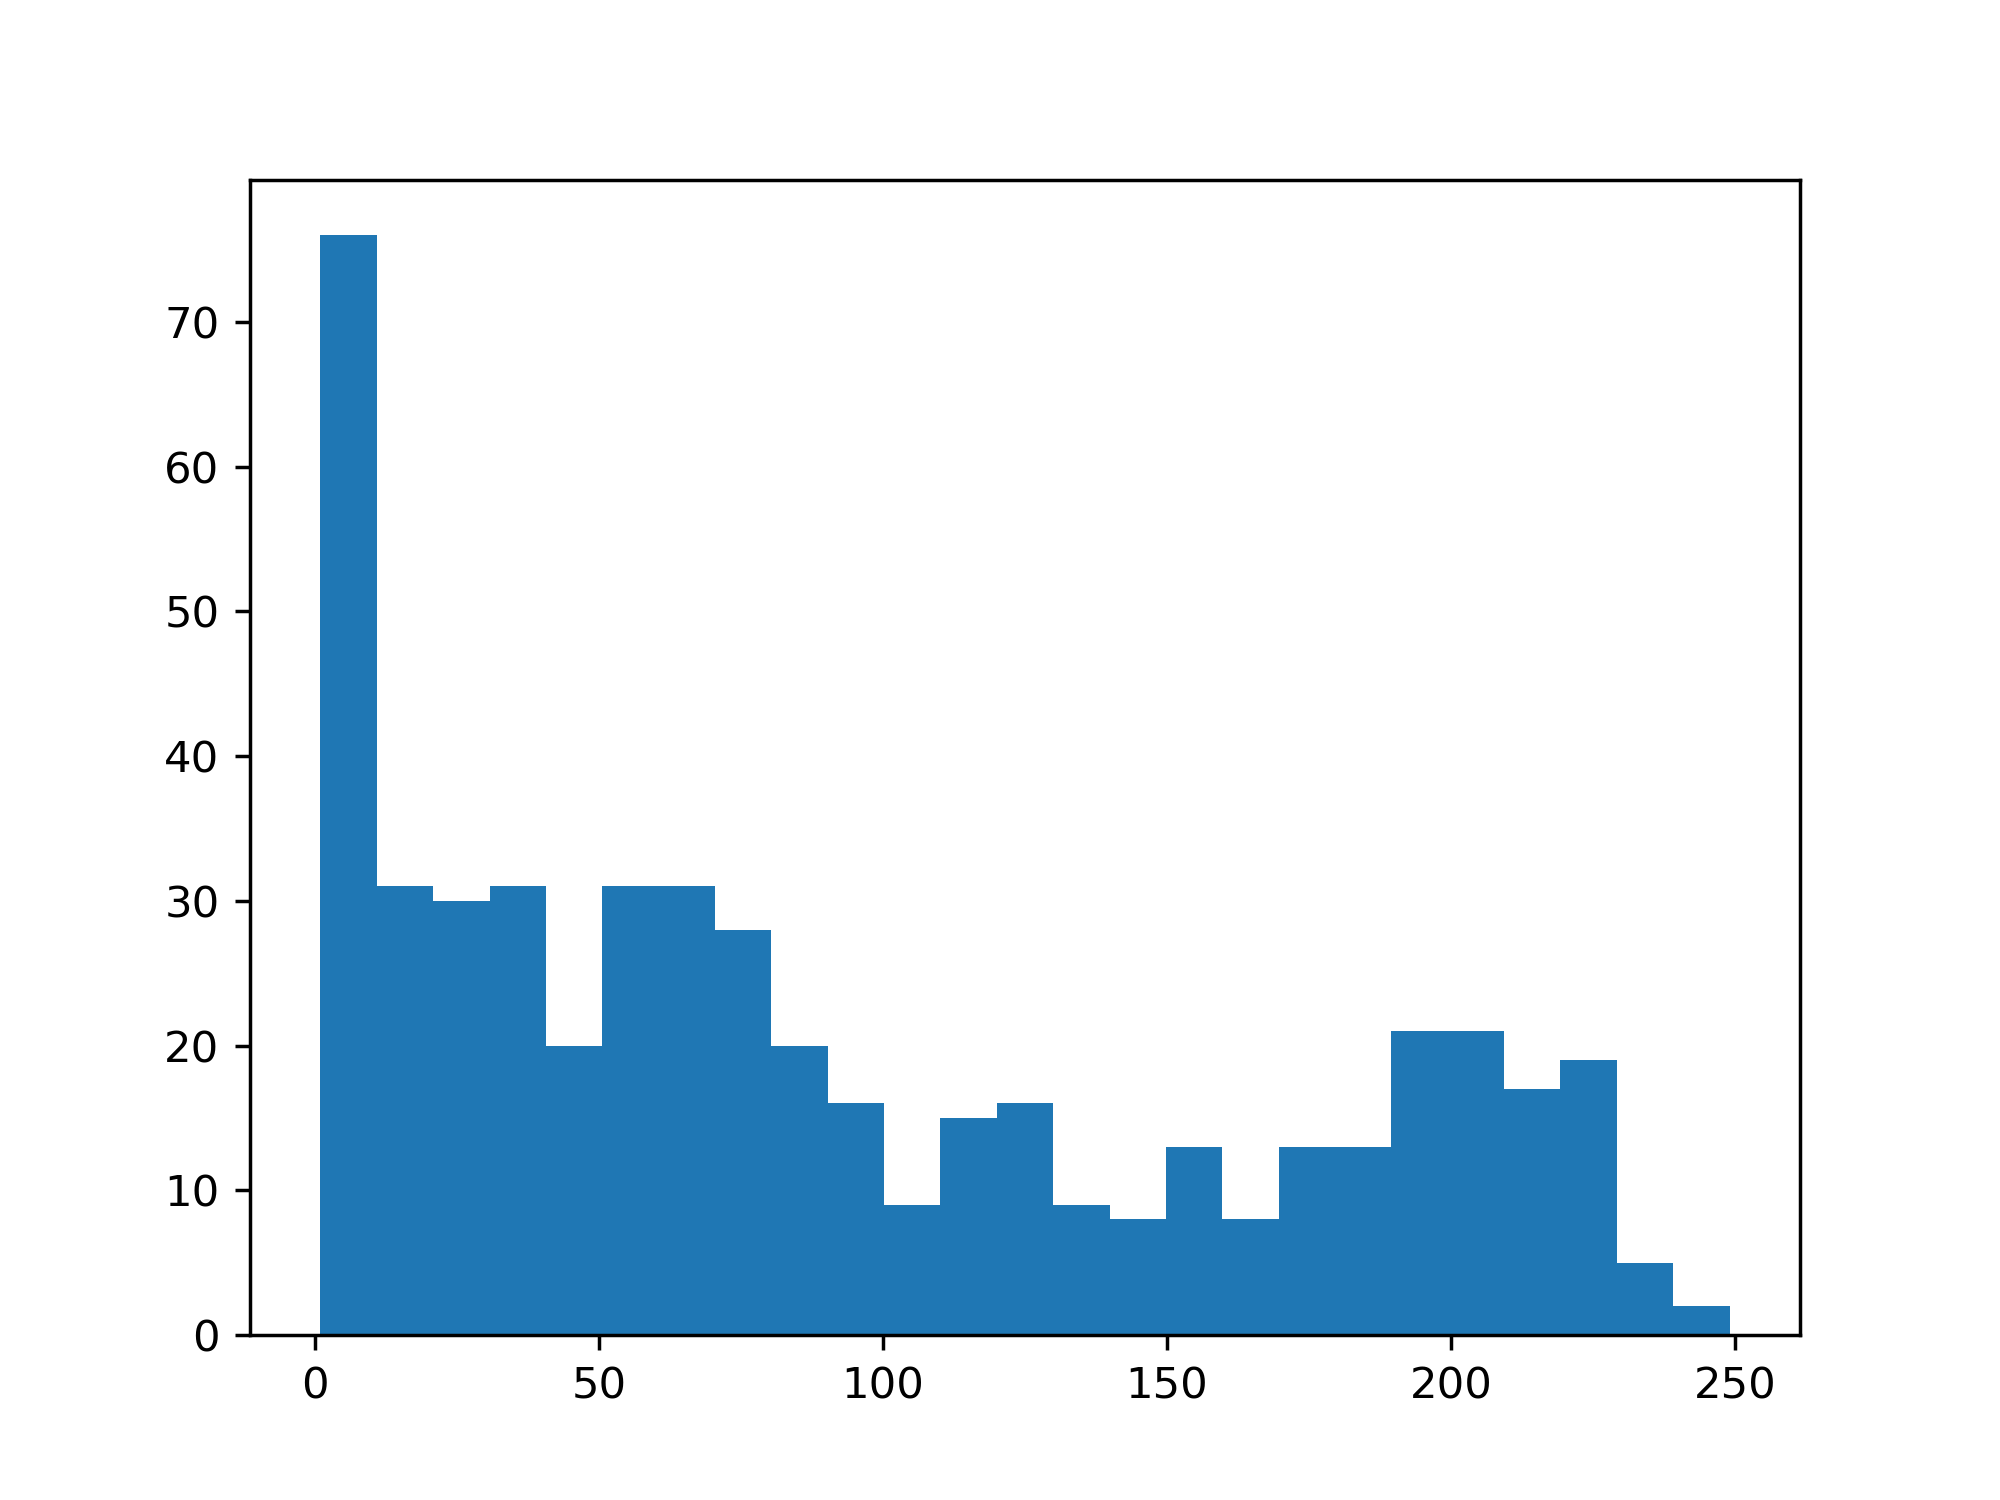

In [253]:
plt.figure()
plt.hist(i_list_count,bins=25)
plt.show()

In [310]:
len(i_list_all)

533

## For debug

In [ ]:
# For debug
start=120
end=180
i_list = sort_data2(start,end,False)
plot_data(ax, i_list, final)
i_list = sort_data2(start,end)
verts = find_verts(i_list, final)
plot_cube(ax, verts)
# final2 = shift_data(i_list)
plot_skeleton(ax, i_list, final2)

plt.show()

In [ ]:
# For debug
# Plot figure in multi-frame
for i in range(0,10):
    i_list = sort_data2(60*i, 60*i+60)
    final2 = shift_data(i_list)
    # plot_data(ax, i_list, final2)
    verts = find_verts(i_list, final2)
    plot_cube(ax, verts, 0.5)
#     plot_skeleton(ax, i_list, final2)

plt.show()

<IPython.core.display.Javascript object>


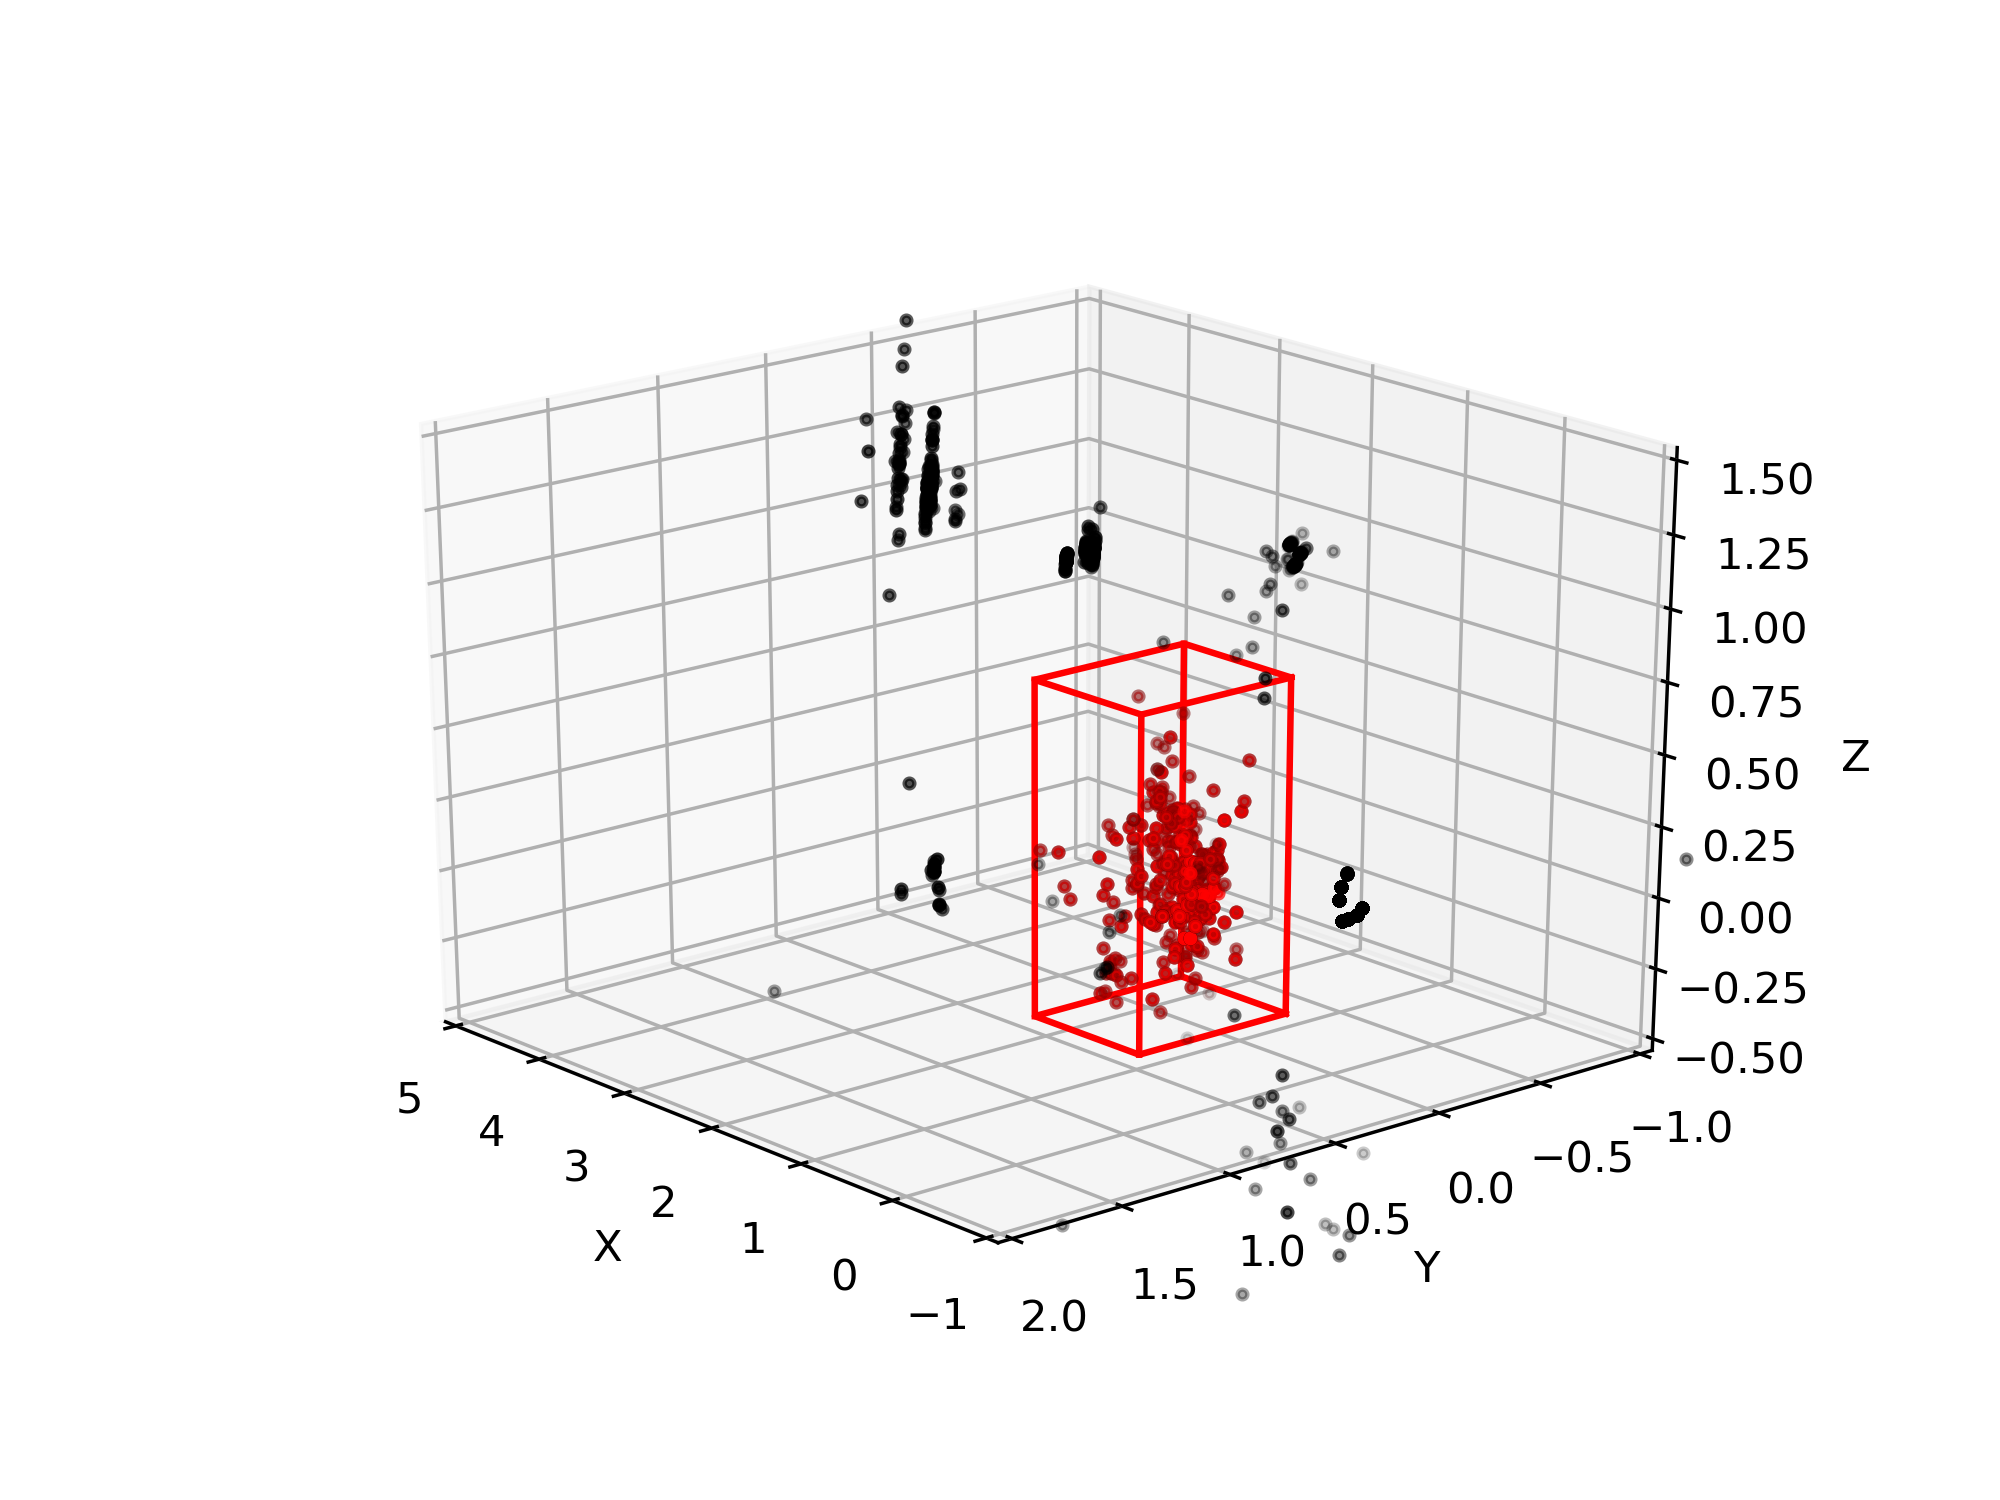

In [314]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)
# i_list=list(np.linspace(0,1382,1383).astype(int))
# i_list=list(np.linspace(1381,2753,1373).astype(int))
i_list=list(np.linspace(2752,3919,1178).astype(int))

# i_list = sort_data2(300,360)
# final2 = shift_data(i_list)
plot_data(ax, i_list, final)
plot_data(ax, i_list_graph3_2[1], final,color="r")
verts = find_verts(i_list_graph3_2[1], final)
plot_cube(ax, verts)

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)
i_list = sort_data(0,60, False)
plot_data(ax, i_list, final)

plt.show()

In [28]:
# Test bounds
pillar = 32
i_prev = 0
i_curr = 1382
find_x_bounds(x[i_prev:i_curr], pillar, True)
find_y_bounds(y[i_prev:i_curr], pillar, True)
find_z_bounds(z[i_prev:i_curr], pillar, True)

plt.show()